In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from rich import print
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
import matplotlib.pyplot as plt

print("[bold green]Libraries Imported: Pandas, Numpy, GeoPandas, Rich, MatPlotLib.[/bold green]")

Libraries Imported: Pandas, Numpy, GeoPandas, Rich, MatPlotLib.

In [ ]:
# All paths

apd_csv = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v3/cleaned_full_atl_v3.csv"
census_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"
campus_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/area_landmark_2024/tl_2023_13_arealm.shp"
og_nhood_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_neighborhood/Official_Neighborhoods_-_Open_Data.shp"

# Loading data

df = pd.read_csv(apd_csv)
print("[bold yellow]Loading data points...[/bold yellow]")
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326"
)

print("[bold green]Loaded[/bold green]", len(gdf_points),"[bold green]points.[/bold green]")

cities = gpd.read_file(census_shp)
campuses = gpd.read_file(campus_shp)
neighborhoods = gpd.read_file(og_nhood_shp)
print("[bold green]Shapefiles loaded.[/bold green]")

Loading data points...

Loaded 19120 points.

Shapefiles loaded.

In [10]:
target_crs = cities.crs
print("[bold yellow]Aligning all crs...[/bold yellow]")

gdf_points = gdf_points.to_crs(target_crs)
campuses = campuses.to_crs(target_crs)
neighborhoods = neighborhoods.to_crs(target_crs)
print("[bold green]CRS aligned.[/bold green]")

Aligning all crs...

CRS aligned.

In [11]:
# Preparing to join layers
print("[bold yellow]Preparing to join layers...[/bold yellow]")
# Layer 1: Campuses
campuses_join = campuses[campuses['MTFCC'] == 'S1400'][['FULLNAME', 'geometry']]
campuses_join = campuses_join.rename(columns={'FULLNAME': 'campus_label'})

# Layer 2: Neighborhoods
neighborhoods_join = neighborhoods[['NAME', 'geometry']]
neighborhoods_join = neighborhoods_join.rename(columns={'NAME': 'neighborhood_label'})

# Layer 3: Cities
cities_join = cities[['NAME', 'geometry']]
cities_join = cities_join.rename(columns={'NAME': 'city_label'})
print("[bold green]Layers ready to join.[/bold green]")

print("[bold yellow]Joining all layers now...[/bold yellow]")

# Join 1: Campuses
joined_df = gpd.sjoin(gdf_points, campuses_join, how="left", predicate="within")

# Join 2: Neighborhoods
joined_df = joined_df.drop('index_right', axis=1, errors='ignore')
joined_df = gpd.sjoin(joined_df, neighborhoods_join, how="left", predicate="within")

# Join 3: Cities
joined_df = joined_df.drop('index_right', axis=1, errors='ignore')
joined_df = gpd.sjoin(joined_df, cities_join, how="left", predicate="within")

print("[bold green]Spatial joins complete![/bold green]")


Preparing to join layers...

Layers ready to join.

Joining all layers now...

Spatial joins complete!

In [12]:
# We create one final column, prioritizing the most granular label
print("Creating final 'location_label' feature...")

conditions = [
    joined_df['campus_label'].notna(),       # Priority 1: Campus
    joined_df['neighborhood_label'].notna(), # Priority 2: Neighborhood
    joined_df['city_label'].notna()          # Priority 3: City
]
choices = [
    joined_df['campus_label'],
    joined_df['neighborhood_label'],
    joined_df['city_label']
]

# Create the new column, defaulting to 'Other' if no match
joined_df['location_label'] = np.select(conditions, choices, default='Other')

# --- 8. CLEAN UP & SAVE FINAL CSV ---
print("Cleaning up final DataFrame...")
# Drop the intermediate helper columns
final_df = joined_df.drop(
    columns=['index_right', 'campus_label', 'neighborhood_label', 'city_label'], 
    errors='ignore'
)

# Convert the GeoDataFrame back to a regular DataFrame for saving
# (This drops the 'geometry' column which is bulky and not needed in the CSV)
final_csv_df = pd.DataFrame(final_df.drop(columns='geometry'))

# Save the new, clean CSV file!
OUTPUT = '/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv'
final_csv_df.to_csv(OUTPUT, index=False)


print(f"Saved new file to: {OUTPUT}")

# --- 9. REVIEW YOUR NEW FEATURE ---
print("\nTop 50 locations from your new 'location_label' column:")
print(final_csv_df['location_label'].value_counts().head(50))

Creating final 'location_label' feature...

Cleaning up final DataFrame...

Saved new file to: 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv

Top 50 locations from your new 'location_label' column:

location_label
Midtown                   1203
Downtown                  1091
College Park               805
Old Fourth Ward            683
Atlanta                    621
West End                   432
Oakland City               358
English Avenue             339
Lakewood Heights           333
Pittsburgh                 301
Sweet Auburn               288
Lindbergh/Morosgo          286
Grove Park                 278
Marietta Street Artery     266
Grant Park                 264
Other                      262
Reynoldstown               238
North Buckhead             234
East Atlanta               225
Campbellton Road           224
Lindridge/Martin Manor     215
Sylvan Hills               210
Edgewood                   197
Southwest                  194
Venetian Hills             192
Virginia Highland          191
Greenbriar                 191
Vine City                  188
Inman Park                 187
Mechanicsville             178
Collier Heights            176
Morningside/Lenox Park     175
Adamsville                 174
Kirkwood                   170
Atlantic Station           157
Harland Terrace            150
Home Park                  147
Piedmont Heights           144
Peoplestown                144
Perkerson                  144
Castleberry Hill           142
Pine Hills                 136
Glenrose Heights           133
Hammond Park               129
South River Gardens        129
Poncey-Highland            126
Adair Park                 125
Berkeley Park              124
East Lake                  121
Center Hill                119
Name: count, dtype: int64

In [4]:
import pandas as pd

# Load the final, cleaned file you just saved
final_df = pd.read_csv('/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv')

# 1. Check your old, broken column
print("--- Old 'NhoodName' Column ---")
print(final_df['NhoodName'].value_counts(dropna=False).head(10))

# 2. Check your new, fixed column
print("\n--- New 'location_label' Column ---")
print(final_df['location_label'].value_counts().head(20))

# 3. Check the "Other" count
other_count = (final_df['location_label'] == 'Other').sum()
print(f"\nRows that failed all 3 joins (should be low): {other_count}")

--- Old 'NhoodName' Column ---
NhoodName
NaN                 1738
Midtown             1203
Downtown            1091
Old Fourth Ward      683
West End             432
Oakland City         358
English Avenue       339
Lakewood Heights     333
Home Park            304
Pittsburgh           301
Name: count, dtype: int64

--- New 'location_label' Column ---
location_label
Midtown                   1203
Downtown                  1091
College Park               805
Old Fourth Ward            683
Atlanta                    621
West End                   432
Oakland City               358
English Avenue             339
Lakewood Heights           333
Pittsburgh                 301
Sweet Auburn               288
Lindbergh/Morosgo          286
Grove Park                 278
Marietta Street Artery     266
Grant Park                 264
Other                      262
Reynoldstown               238
North Buckhead             234
East Atlanta               225
Campbellton Road           224
Name: count

262 had no match, marked as other. May be highway, cemetary, etc?

In [13]:
import pandas as pd
from rich.console import Console
from rich.table import Table

# --- 1. Load your CSV ---
csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv"
try:
    final_df = pd.read_csv(csv_path)
    # --- 2. Get the value counts ---
    location_counts = final_df['location_label'].value_counts()

    # --- 3. Create a Rich Table ---
    table = Table(title="Location Label Value Counts", show_header=True, header_style="bold magenta")
    table.add_column("Location Label", style="dim", width=40)
    table.add_column("Count", justify="right")

    # --- 4. Add data to the table ---
    for location, count in location_counts.items():
        table.add_row(location, str(count))

    # --- 5. Print the table ---
    console = Console()
    console.print(table)

except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
except Exception as e:
    print(f"An error occurred: {e}")

            Location Label Value Counts             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Location Label                           ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Midtown                                  │  1203 │
│ Downtown                                 │  1091 │
│ College Park                             │   805 │
│ Old Fourth Ward                          │   683 │
│ Atlanta                                  │   621 │
│ West End                                 │   432 │
│ Oakland City                             │   358 │
│ English Avenue                           │   339 │
│ Lakewood Heights                         │   333 │
│ Pittsburgh                               │   301 │
│ Sweet Auburn                             │   288 │
│ Lindbergh/Morosgo                        │   286 │
│ Grove Park                               │   278 │
│ Marietta Street Artery                   │   266 │
│ Grant Park                               │   264 │
│ Other                                    │   262 │
│ Reynoldstown                             │   238 │
│ North Buckhead                           │   234 │
│ East Atlanta                             │   225 │
│ Campbellton Road                         │   224 │
│ Lindridge/Martin Manor                   │   215 │
│ Sylvan Hills                             │   210 │
│ Edgewood                                 │   197 │
│ Southwest                                │   194 │
│ Venetian Hills                           │   192 │
│ Virginia Highland                        │   191 │
│ Greenbriar                               │   191 │
│ Vine City                                │   188 │
│ Inman Park                               │   187 │
│ Mechanicsville                           │   178 │
│ Collier Heights                          │   176 │
│ Morningside/Lenox Park                   │   175 │
│ Adamsville                               │   174 │
│ Kirkwood                                 │   170 │
│ Atlantic Station                         │   157 │
│ Harland Terrace                          │   150 │
│ Home Park                                │   147 │
│ Piedmont Heights                         │   144 │
│ Peoplestown                              │   144 │
│ Perkerson                                │   144 │
│ Castleberry Hill                         │   142 │
│ Pine Hills                               │   136 │
│ Glenrose Heights                         │   133 │
│ Hammond Park                             │   129 │
│ South River Gardens                      │   129 │
│ Poncey-Highland                          │   126 │
│ Adair Park                               │   125 │
│ Berkeley Park                            │   124 │
│ East Lake                                │   121 │
│ Center Hill                              │   119 │
│ Loring Heights                           │   115 │
│ Adams Park                               │   114 │
│ Lenox                                    │   111 │
│ Princeton Lakes                          │   106 │
│ Fairburn Mays                            │   102 │
│ South Atlanta                            │   102 │
│ Dixie Hills                              │    99 │
│ Cascade Avenue/Road                      │    99 │
│ Westview                                 │    98 │
│ Summerhill                               │    96 │
│ Ashview Heights                          │    94 │
│ South Tuxedo Park                        │    94 │
│ Ormewood Park                            │    93 │
│ Browns Mill Park                         │    90 │
│ Underwood Hills                          │    89 │
│ Bolton                                   │    87 │
│ Blandtown                                │    87 │
│ Riverside                                │    85 │
│ Buckhead Village                         │    84 │
│ Capitol View                             │    83 │
│ Florida Heights                          │    80 │
│ Custer/McDonough/Guice 

In [17]:
%pip install adjustText

Note: you may need to restart the kernel to use updated packages.


Creating cleaner validation map...
Adjusting labels...


/tmp/ipykernel_117198/2635065571.py:75: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left')


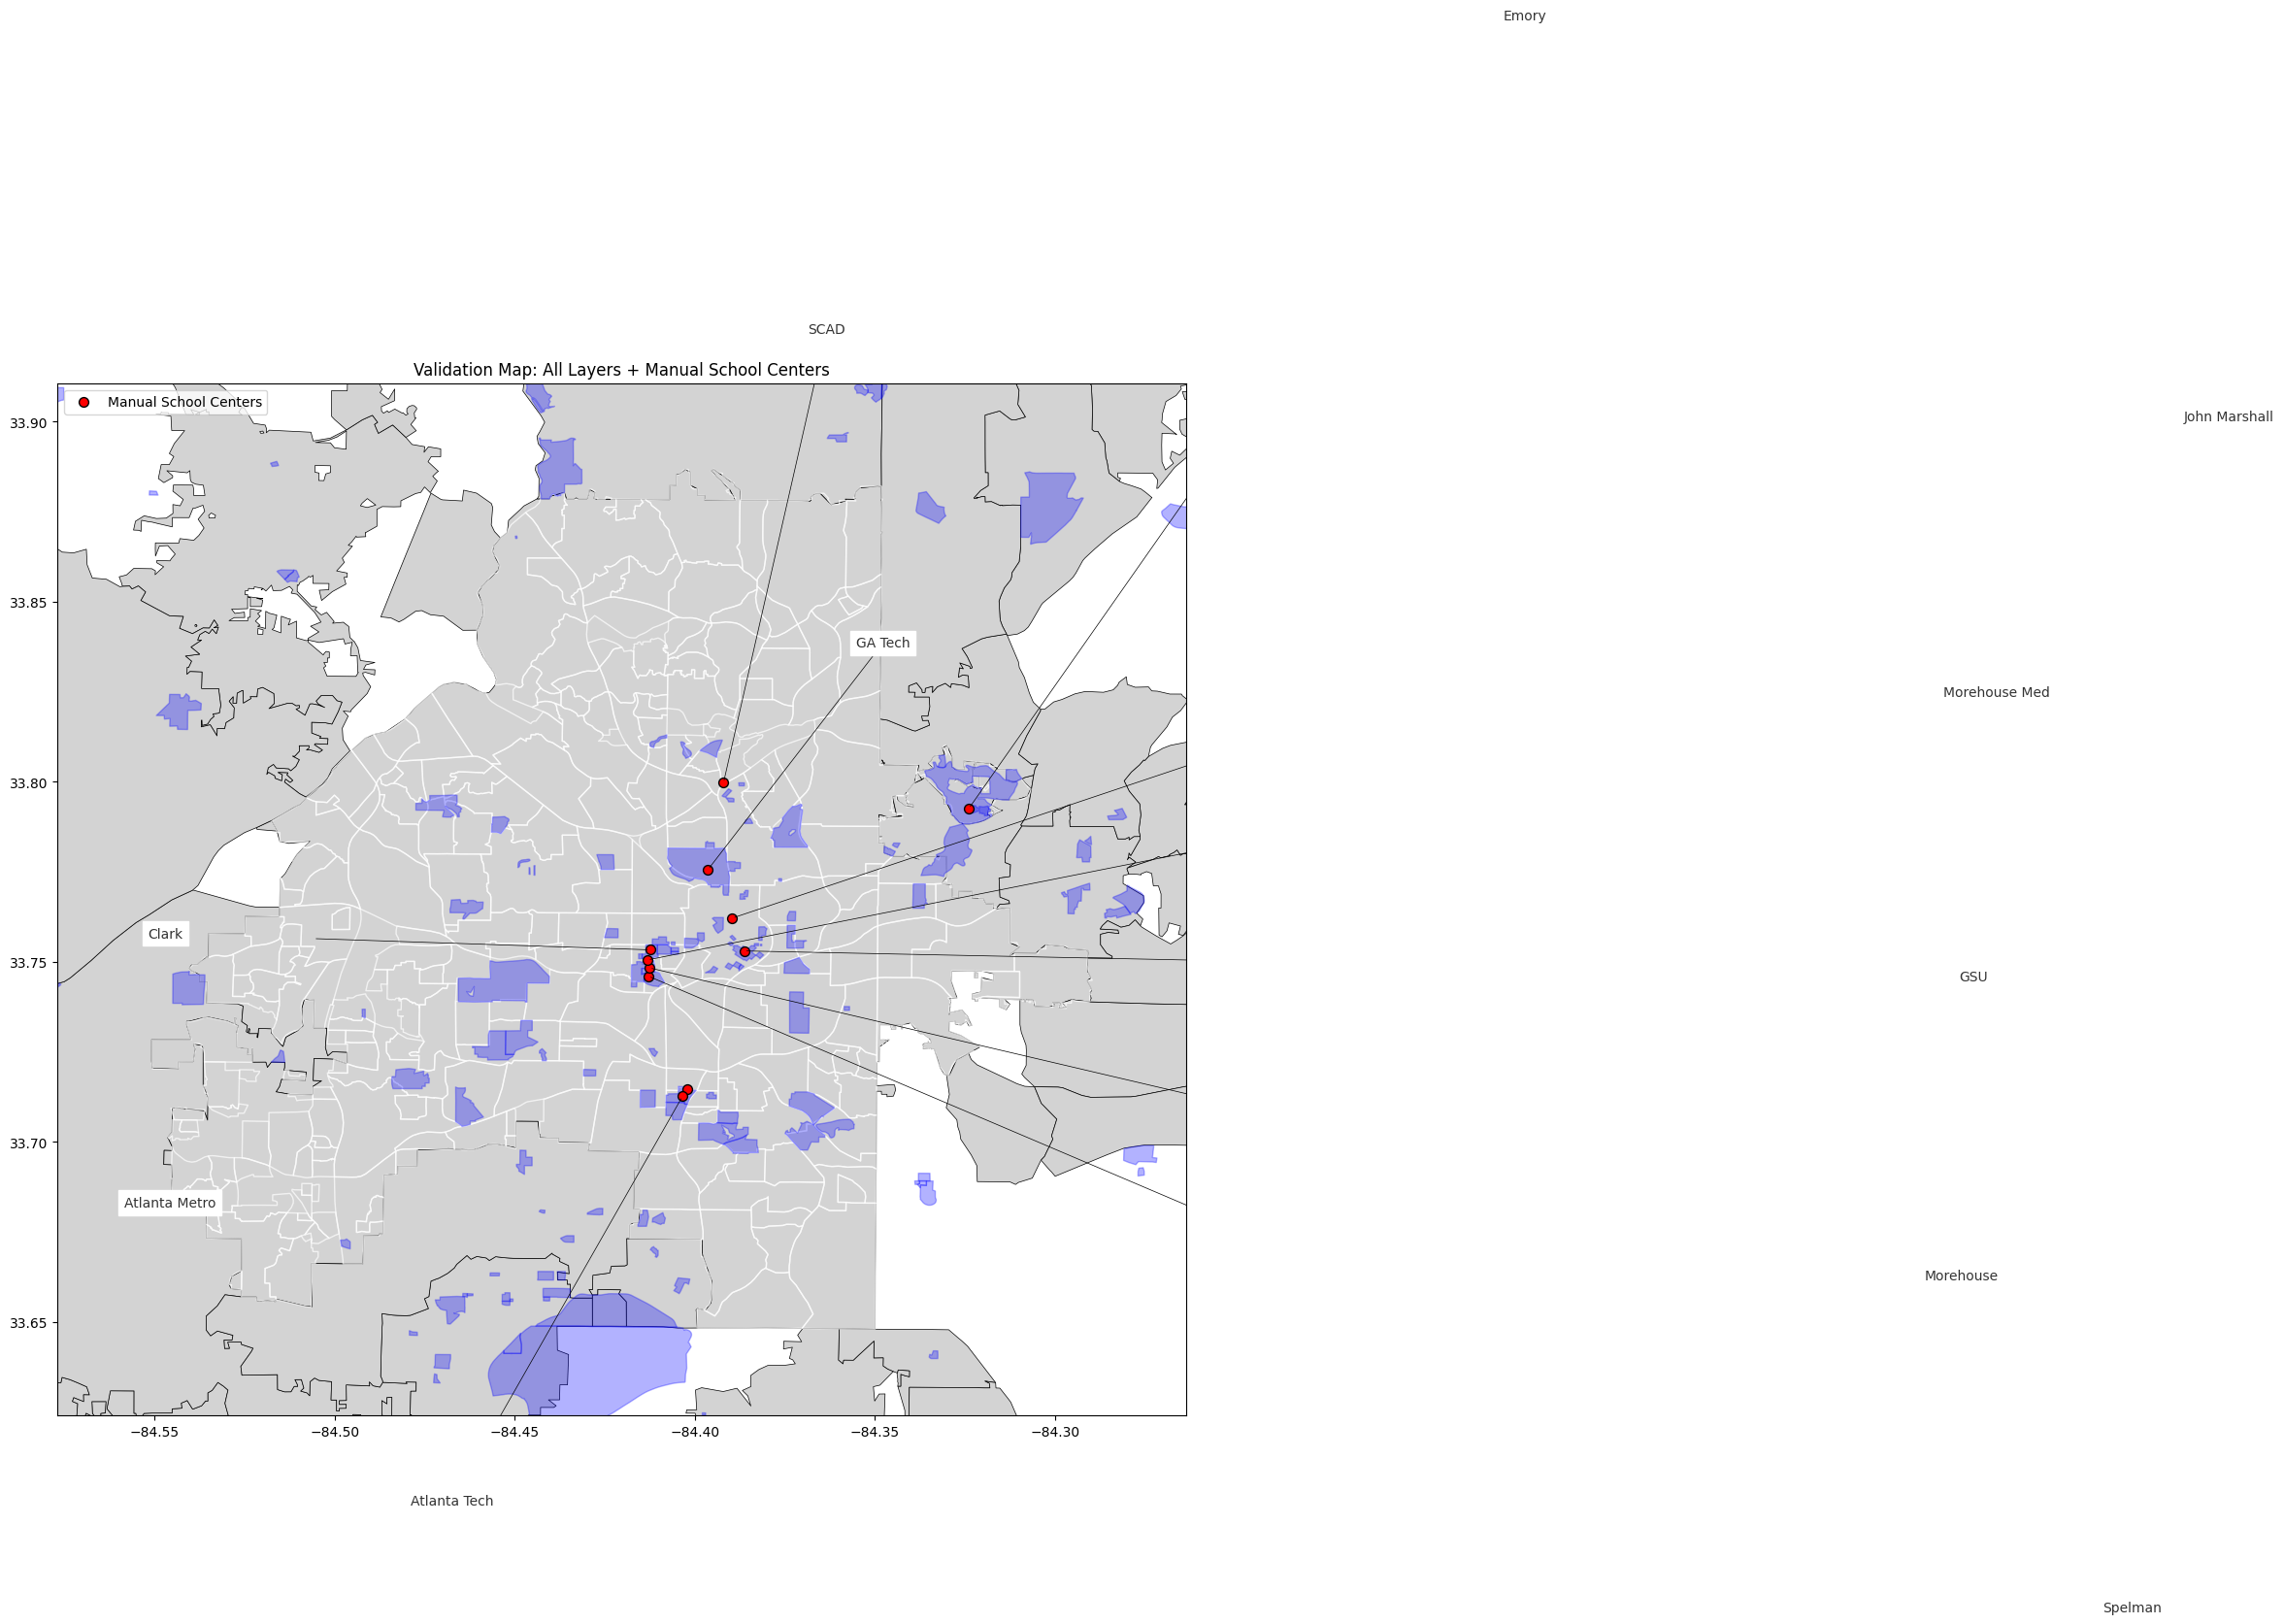

In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from adjustText import adjust_text

# --- 1. DEFINE YOUR SCHOOL ACRONYMS ---
school_acronyms = {
    'GSU': (33.7530, -84.3863),
    'GA Tech': (33.7756, -84.3963),
    'Emory': (33.7925, -84.3239),
    'Clark': (33.7533, -84.4124),
    'Spelman': (33.7460, -84.4129),
    'Morehouse': (33.7483, -84.4126),
    'Morehouse Med': (33.7505, -84.4131),
    'Atlanta Metro': (33.7145, -84.4020),
    'Atlanta Tech': (33.7126, -84.4034),
    'SCAD': (33.7997, -84.3920),
    'John Marshall': (33.7621, -84.3896)
}

# --- 2. LOAD SHAPEFILES & CONVERT POINTS (Same as before) ---
# (Assuming 'cities', 'campuses', 'neighborhoods' are loaded)

df_schools = pd.DataFrame(school_acronyms.items(), columns=['School', 'Coordinates'])
df_schools['geometry'] = [Point(lon, lat) for lat, lon in df_schools['Coordinates']]
gdf_schools = gpd.GeoDataFrame(df_schools, geometry='geometry', crs="EPSG:4326")

# --- 3. ALIGN ALL CRS (Same as before) ---
target_crs = cities.crs
cities = cities.to_crs(target_crs)
campuses = campuses.to_crs(target_crs)
neighborhoods = neighborhoods.to_crs(target_crs)
gdf_schools = gdf_schools.to_crs(target_crs)

# --- 4. PLOT EVERYTHING ---
print("Creating cleaner validation map...")
fig, ax = plt.subplots(figsize=(15, 15))

# Layer 1: Cities (Gray base)
cities.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5, label='City Boundaries')
# Layer 2: Neighborhoods (White outlines)
neighborhoods.plot(ax=ax, color='none', edgecolor='white', linewidth=1.0, alpha=0.7, label='Neighborhoods')
# Layer 3: Flawed Census shapes (Blue blobs)
campuses.plot(ax=ax, color='blue', edgecolor='blue', alpha=0.3, label='Census "Landmark" Shapes')

# --- 5. UPDATED PLOT: PLOT SCHOOLS AS DOTS (No stars) ---
gdf_schools.plot(
    ax=ax,
    color='red',
    marker='o',  # <-- Use a circle marker
    markersize=50,  # <-- Make it smaller
    edgecolor='black',
    label='Manual School Centers'
)

# --- 6. FIX ASPECT RATIO (Same as before) ---
ax.set_aspect('equal')

# --- 7. ADD NON-OVERLAPPING LABELS (Same as before) ---
print("Adjusting labels...")
texts = []
for x, y, label in zip(gdf_schools.geometry.x, gdf_schools.geometry.y, gdf_schools['School']):
    texts.append(ax.text(x, y, label, backgroundcolor="white", alpha=0.8, fontsize=10))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# --- 8. ZOOM & STYLE (Same as before) ---
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)

ax.set_title("Validation Map: All Layers + Manual School Centers")
ax.legend(loc='upper left')
plt.show()

Loading base map files...
Converting 19120 crime points...
Aligning all layers to CRS: NAD83...
Plotting all crime points by location label...


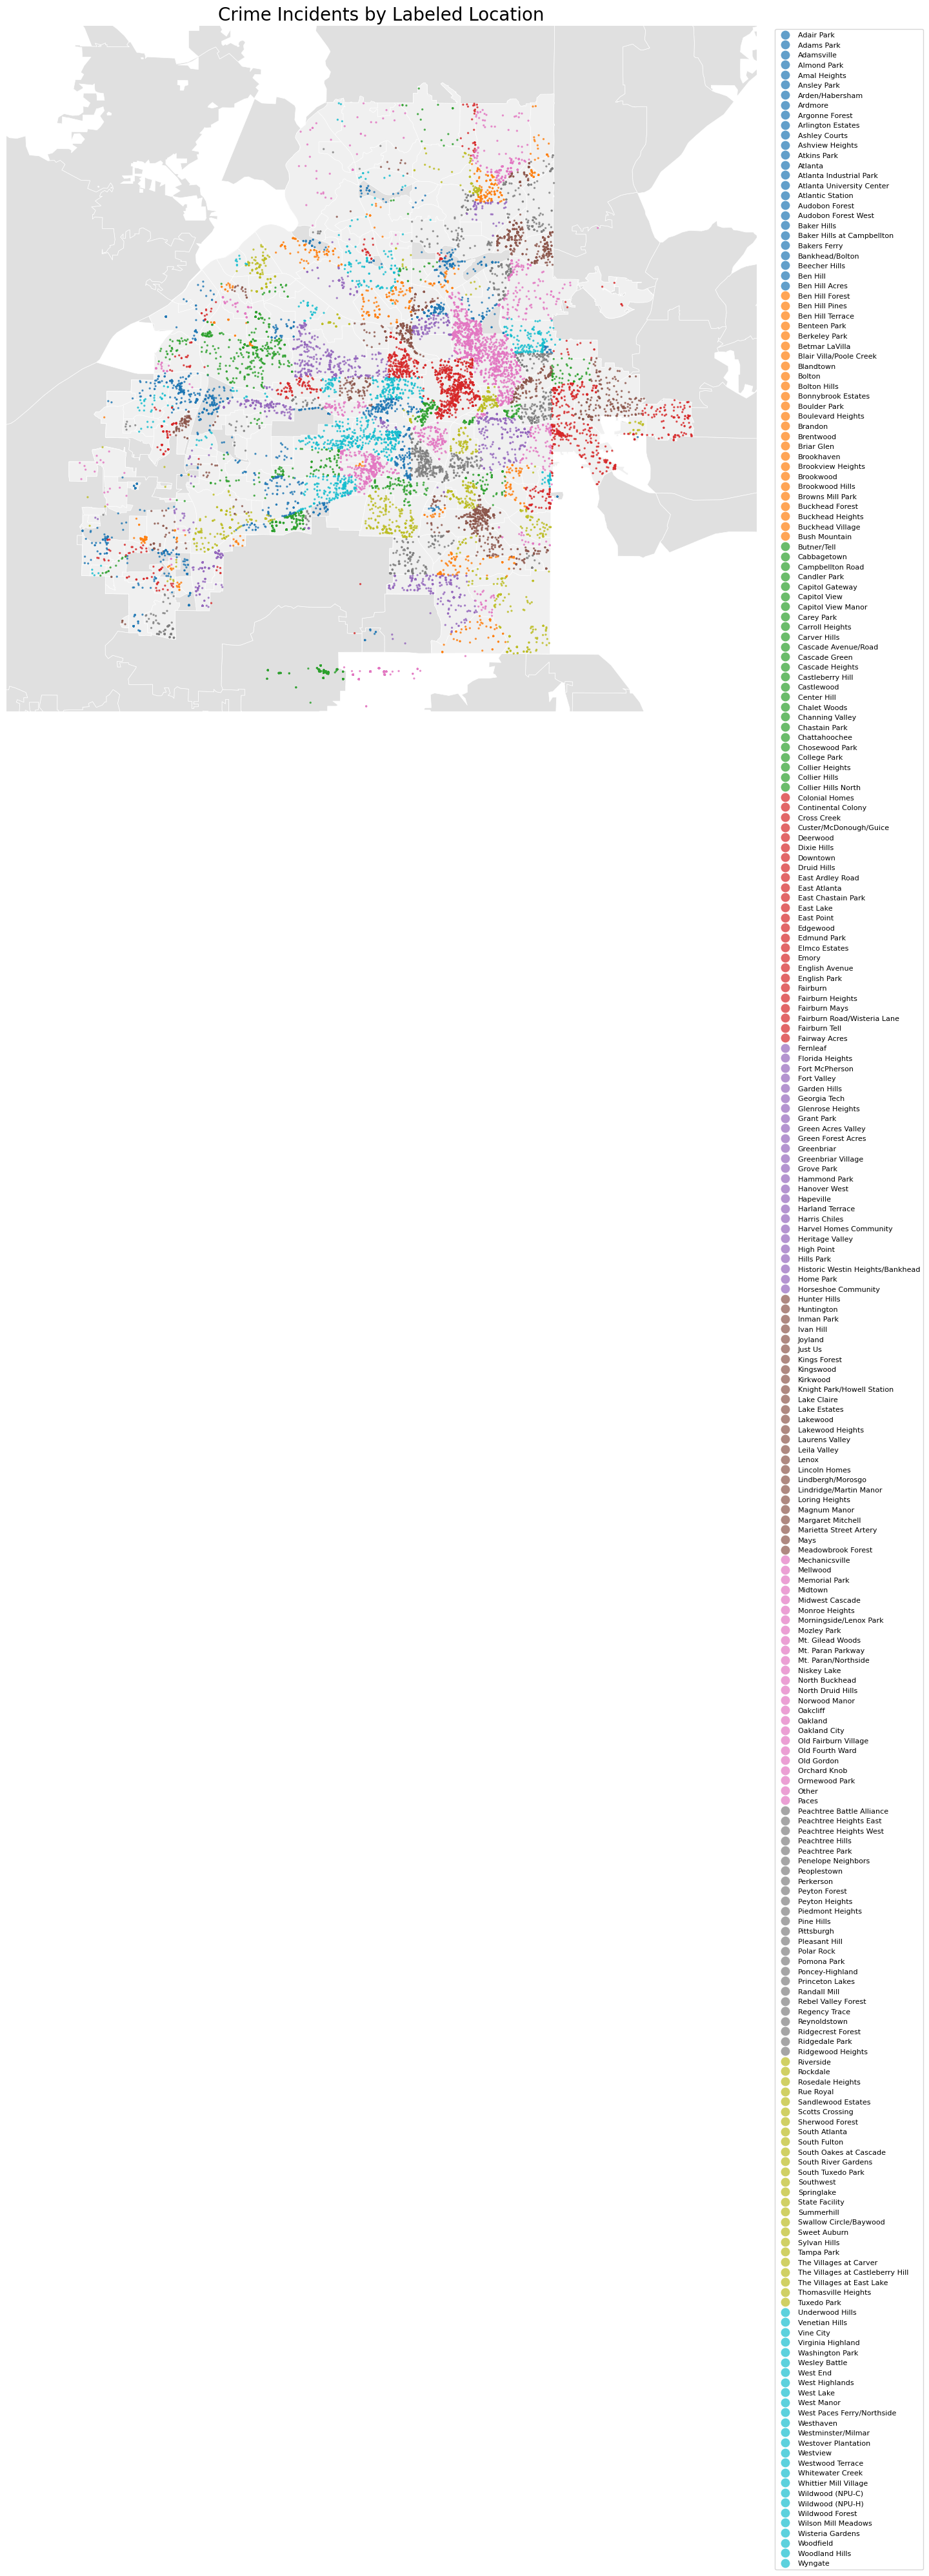

In [20]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. LOAD YOUR FINAL, CLEANED CRIME DATA ---
# Use the CSV file that has your new 'location_label'
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv"
final_df = pd.read_csv(crime_csv_path)

# --- 2. LOAD YOUR BASEMAP SHAPEFILES (Keep it simple) ---
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"
og_nhood_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_neighborhood/Official_Neighborhoods_-_Open_Data.shp"

print("Loading base map files...")
cities = gpd.read_file(cities_shp)
neighborhoods = gpd.read_file(og_nhood_shp)

# --- 3. CONVERT YOUR CRIME DATA TO A GeoDataFrame ---
print(f"Converting {len(final_df)} crime points...")
# Make sure your Longitude/Latitude column names are correct!
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326" # Start with lat/lon
)

# --- 4. ALIGN ALL CRS (Critical!) ---
target_crs = cities.crs
print(f"Aligning all layers to CRS: {target_crs.name}...")
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)
neighborhoods = neighborhoods.to_crs(target_crs)

# --- 5. PLOT THE *REAL* MAP ---
print("Plotting all crime points by location label...")
fig, ax = plt.subplots(figsize=(15, 15))

# Layer 1: Plot cities as the absolute base (light gray)
cities.plot(ax=ax, color='#E0E0E0', edgecolor='white', linewidth=0.5)

# Layer 2: Plot neighborhood outlines on top (darker gray)
neighborhoods.plot(ax=ax, color='#F0F0F0', edgecolor='white', linewidth=0.5)

# Layer 3: Plot your CRIME DATA, colored by label
gdf_crime.plot(
    ax=ax,
    column='location_label',  # <-- The magic is here
    categorical=True,         # Use distinct colors
    markersize=2,             # Make points small
    alpha=0.7,                # Add transparency
    legend=True,              # Show the key
    legend_kwds={
        'loc': 'upper left', 
        'bbox_to_anchor': (1.02, 1), # Put legend outside plot
        'fontsize': 8
    }
)

# --- 6. CLEAN UP THE MAP ---
ax.set_aspect('equal') # Fix the "janky" stretching

# Zoom in on Atlanta
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)

ax.set_title("Crime Incidents by Labeled Location", fontsize=20)
ax.axis('off') # Hide the ugly axes
plt.show()

Loading data...
Converting 19120 crime points...
Plotting crime points by 'Zone_int'...
Building custom legend with counts...


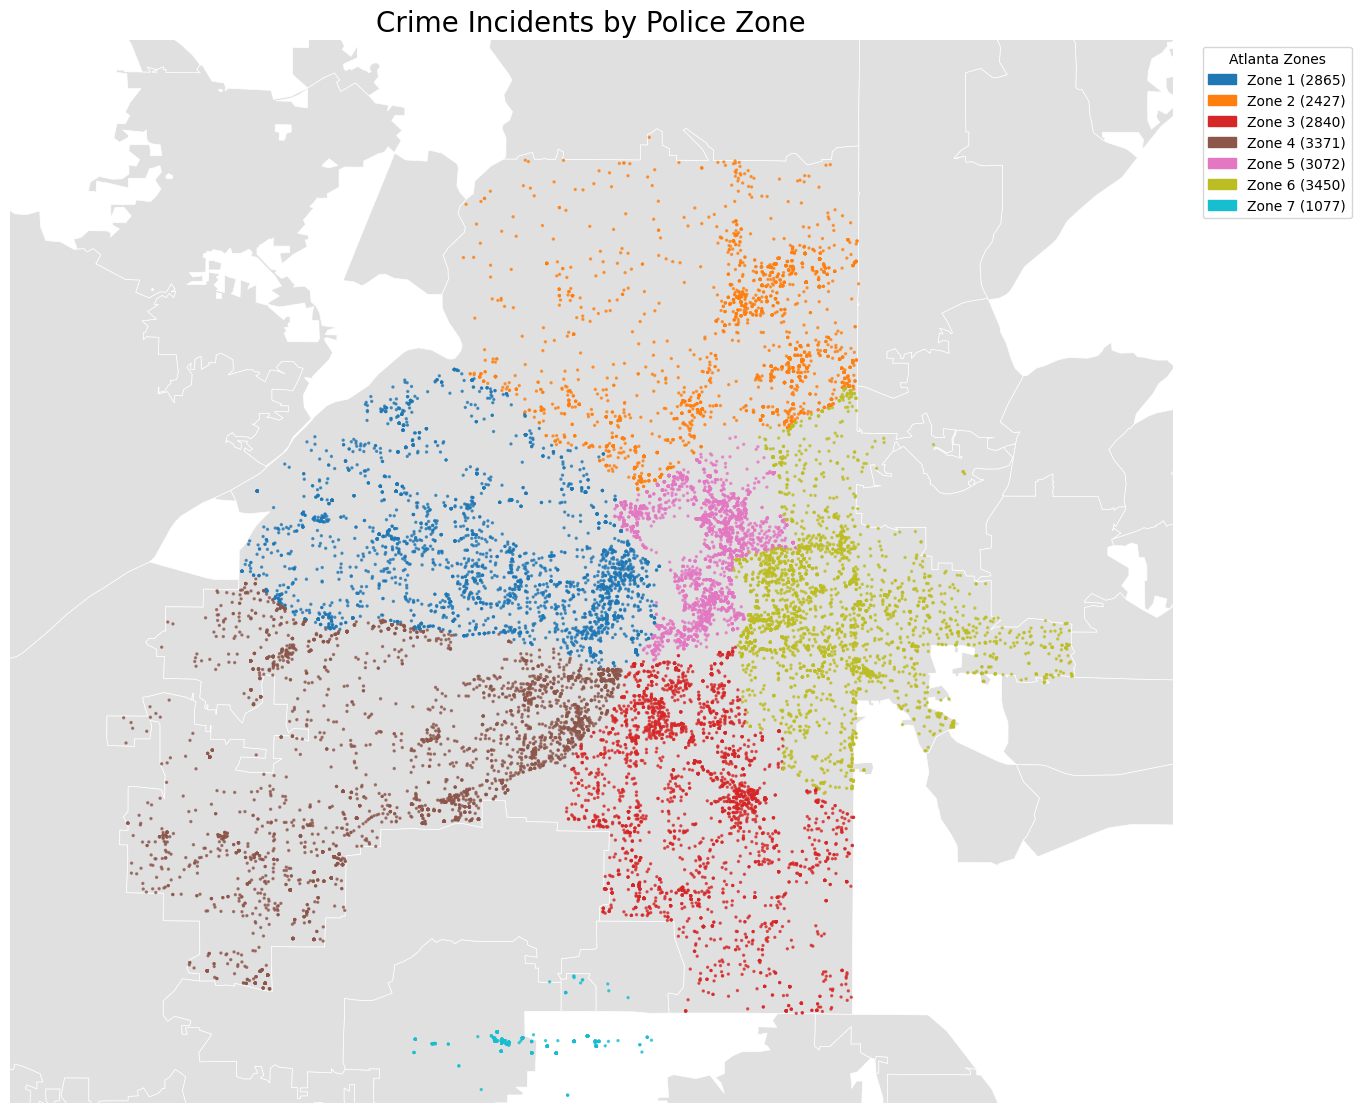

In [27]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # <-- 1. Import for manual legend
import matplotlib.colors as mcolors    # <-- 2. Import for colors

# --- 1. LOAD YOUR DATA (Same as before) ---
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv"
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"

print("Loading data...")
final_df = pd.read_csv(crime_csv_path)
cities = gpd.read_file(cities_shp)

# --- 2. CONVERT CRIME DATA TO GeoDataFrame (Same as before) ---
print(f"Converting {len(final_df)} crime points...")
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326"
)

# --- 3. ALIGN CRS (Same as before) ---
target_crs = cities.crs
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)

# --- 4. PLOT BY YOUR 'zone_int' COLUMN (MODIFIED) ---
print("Plotting crime points by 'Zone_int'...")
fig, ax = plt.subplots(figsize=(15, 15))

# Plot basemap
cities.plot(ax=ax, color='#E0E0E0', edgecolor='white', linewidth=0.5)

# Plot your crime data
gdf_crime.plot(
    ax=ax,
    column='Zone_int',
    categorical=True,
    cmap='tab10',  # <-- We must remember this colormap
    markersize=2,
    alpha=0.7,
    legend=False  # <-- 5. Turn off the default legend
)

# --- 6. NEW: BUILD THE CUSTOM LEGEND ---
print("Building custom legend with counts...")

# Get the counts for each zone, sorted by zone number
zone_counts = gdf_crime['Zone_int'].value_counts().sort_index()

# Get the list of unique zones to map colors
unique_zones = zone_counts.index.tolist()
num_zones = len(unique_zones)
cmap = plt.get_cmap('tab10') # Get the same colormap
norm = mcolors.Normalize(vmin=0, vmax=num_zones - 1) # Create a normalizer

# Create a color map {zone_number: color}
color_map = {zone: cmap(norm(i)) for i, zone in enumerate(unique_zones)}

# Create the list of "patches" for the legend
legend_patches = []
for zone in zone_counts.index:
    # Format the label just as you wanted
    label = f"Zone {int(zone)} ({zone_counts[zone]})"
    
    # Create the color patch
    patch = mpatches.Patch(color=color_map[zone], label=label)
    legend_patches.append(patch)

# Add the new, custom legend to the plot
ax.legend(
    handles=legend_patches, # Use our custom patches
    title='Atlanta Zones',
    loc='upper left', 
    bbox_to_anchor=(1.02, 1) # Put it outside the plot
)

# --- 7. CLEAN UP (Same as before) ---
ax.set_aspect('equal')
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)
ax.set_title("Crime Incidents by Police Zone", fontsize=20)
ax.axis('off')
plt.show()

Missing around 20 datapoints based on zone.

In [29]:
import pandas as pd
import numpy as np
from rich.console import Console
from rich import print

# --- 1. SETUP ---
console = Console()

# Define your file paths
in_file = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv"
out_file = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/cleaned_full_atl_v6.csv"

console.print(f"Loading data from [cyan]{in_file}[/cyan]...", style="bold blue")
try:
    df = pd.read_csv(in_file)
except FileNotFoundError:
    console.print(f"Error: File not found at {in_file}", style="bold red")
    # Exit or raise error
    exit()

# --- 2. REPORT 'BEFORE' STATE ---
nan_before = df['Zone_int'].isna().sum()
console.print(f"Original missing 'Zone_int' values: [bold red]{nan_before}[/bold red]")

# --- 3. CREATE THE IMPUTATION MAP ---
console.print("Creating imputation map (location_label -> most common Zone_int)...")

# We create the map by:
# 1. Dropping all rows that *already* have a NaN zone (we can't learn from them)
# 2. Grouping by 'location_label'
# 3. Finding the 'mode' (most common) Zone_int for each label.
#    .iloc[0] just selects the first item (the mode)
location_to_zone_map = df.dropna(subset=['Zone_int']).groupby('location_label')['Zone_int'].apply(lambda x: x.mode().iloc[0])

console.print("--- Imputation Map Created ---", style="bold green")
print(location_to_zone_map)
console.print("--------------------------------")
console.print("[dim]Note: Labels not in this list (e.g., 'East Point') have no valid zone, and will correctly remain NaN.[/dim]")

# --- 4. APPLY THE IMPUTATION ---
console.print("Imputing missing values...")

# Create a new, cleaned column.
# We fill the NaN values by looking up the row's 'location_label' in our new map.
df['Zone_int_cleaned'] = df['Zone_int'].fillna(df['location_label'].map(location_to_zone_map))

# --- 5. REPORT 'AFTER' STATE ---
nan_after = df['Zone_int_cleaned'].isna().sum()
filled_count = nan_before - nan_after

console.print(f"Successfully imputed [bold yellow]{filled_count}[/bold yellow] values.")
console.print(f"Remaining missing 'Zone_int' values: [bold green]{nan_after}[/bold green]")
console.print(f"[dim](These {nan_after} are for locations outside APD zones, like 'East Point')")

# --- 6. SAVE THE NEW CSV ---
console.print(f"\nSaving new CSV to [cyan]{out_file}[/cyan]...", style="bold blue")
df.to_csv(out_file, index=False)

console.print("--- Success! ---", style="bold green")

Loading data from 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv...

Original missing 'Zone_int' values: 18

Creating imputation map (location_label -> most common Zone_int)...

--- Imputation Map Created ---

location_label
Adair Park             3.0
Adams Park             4.0
Adamsville             4.0
Almond Park            1.0
Amal Heights           3.0
                      ... 
Wilson Mill Meadows    4.0
Wisteria Gardens       4.0
Woodfield              2.0
Woodland Hills         6.0
Wyngate                2.0
Name: Zone_int, Length: 252, dtype: float64

--------------------------------

Note: Labels not in this list (e.g., 'East Point') have no valid zone, and will correctly remain NaN.

Imputing missing values...

Successfully imputed 17 values.

Remaining missing 'Zone_int' values: 1

(These 1 are for locations outside APD zones, like 'East Point')

Saving new CSV to 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/cleaned_full_atl_v6.csv...

--- Success! ---

Loading data...

Converting 19120 crime points...

Aligning Coordinate Reference Systems...

Plotting crime points by 'Zone_int_cleaned'...

Building custom legend with counts...

Plot generated successfully.

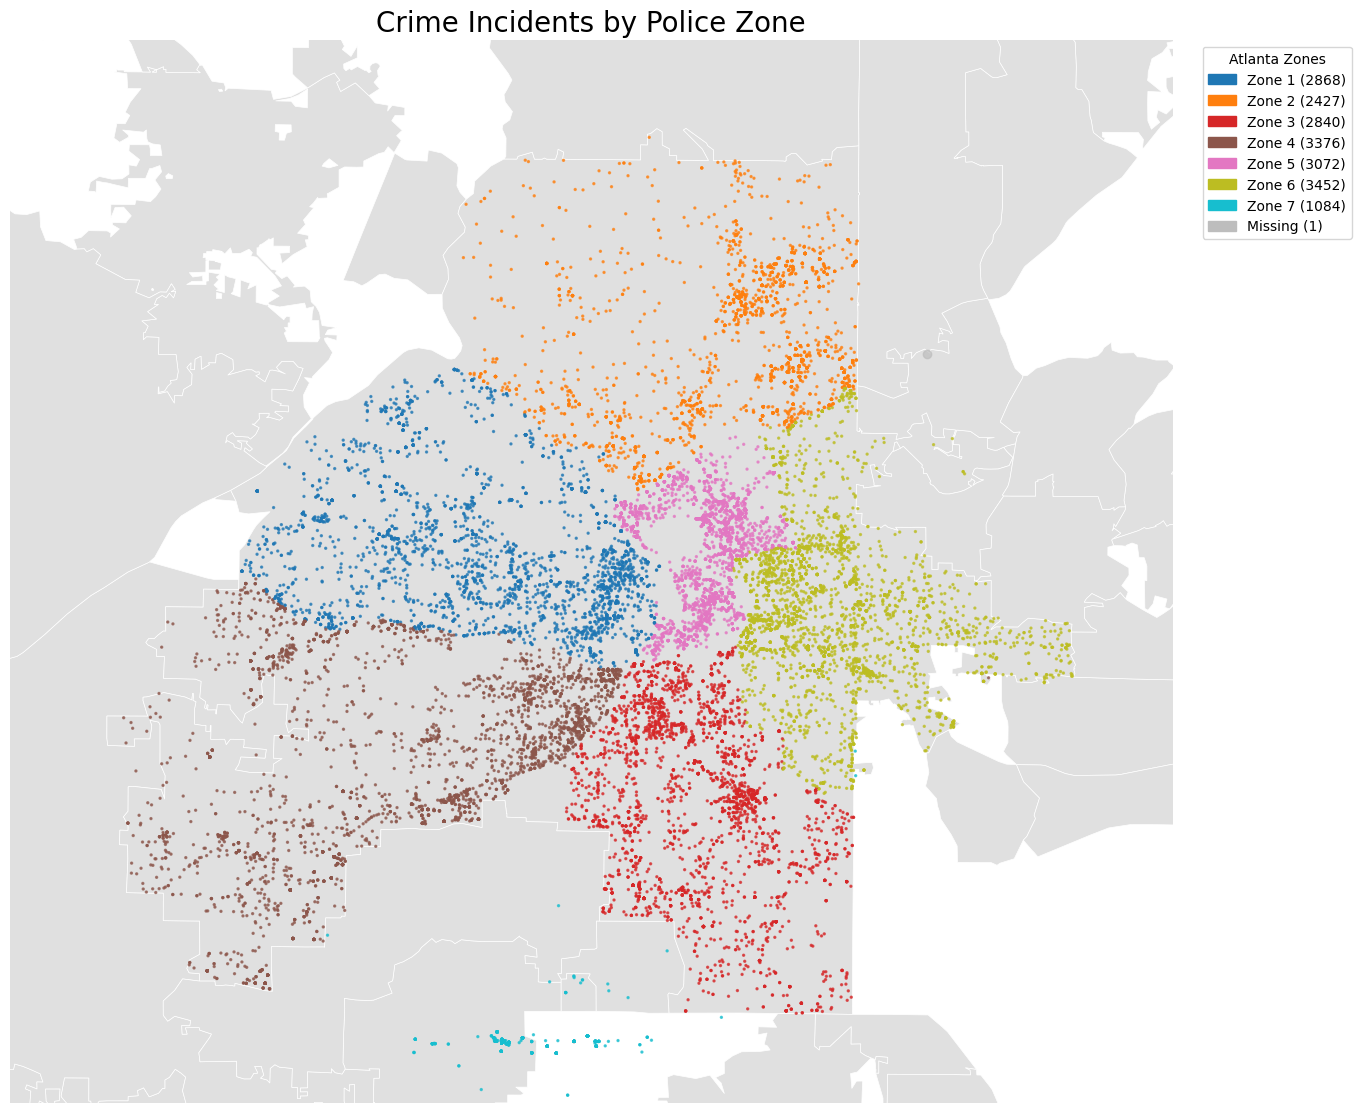

In [33]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from rich.console import Console

# --- 0. Setup ---
console = Console()

# --- 1. LOAD YOUR *NEW* DATA ---
# NEW/FIXED: Path updated to your v6 file
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/cleaned_full_atl_v6.csv" 
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"

console.print("Loading data...", style="bold blue")
final_df = pd.read_csv(crime_csv_path)
cities = gpd.read_file(cities_shp)

# --- 2. CONVERT CRIME DATA TO GeoDataFrame ---
console.print(f"Converting [cyan]{len(final_df)}[/cyan] crime points...", style="bold blue")
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326"
)

# --- 3. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = cities.crs
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)

# --- 4. PLOT BY YOUR 'Zone_int_cleaned' COLUMN ---
console.print("Plotting crime points by 'Zone_int_cleaned'...", style="bold blue")
fig, ax = plt.subplots(figsize=(15, 15))

# Plot basemap
cities.plot(ax=ax, color='#E0E0E0', edgecolor='white', linewidth=0.5)
missing_color = '#BDBDBD' # A neutral gray

gdf_crime.plot(
    ax=ax,
    column='Zone_int_cleaned', # NEW/FIXED: Use the cleaned column
    categorical=True,
    cmap='tab10',
    markersize=2,
    alpha=0.7,
    legend=False,
    missing_kwds={ # Color the one NaN point gray
        "color": missing_color
    }
)

# --- 6. BUILD THE CUSTOM LEGEND ---
console.print("Building custom legend with counts...", style="dim")

# Get counts, including the 1 NaN value
zone_counts = gdf_crime['Zone_int_cleaned'].value_counts(dropna=False) # NEW/FIXED: Use the cleaned column

# Get valid zones (no NaN) to map colors
# --- NEW/FIXED: This is the bug fix. We dropna() on the *index*, not the Series.
valid_zones_index = zone_counts.index.dropna()
unique_zones = valid_zones_index.sort_values().tolist()
# --- END FIX ---

num_zones = len(unique_zones)
cmap = plt.get_cmap('tab10')
norm = mcolors.Normalize(vmin=0, vmax=num_zones - 1)

color_map = {zone: cmap(norm(i)) for i, zone in enumerate(unique_zones)}
legend_patches = []

# Add valid zones first, in order
for zone in unique_zones:
    label = f"Zone {int(zone)} ({zone_counts[zone]})" # This line is now safe
    patch = mpatches.Patch(color=color_map[zone], label=label)
    legend_patches.append(patch)

# Manually add the NaN/Missing patch
nan_keys = [key for key in zone_counts.index if pd.isna(key)]
if nan_keys:
    nan_count = zone_counts[nan_keys[0]]
    if nan_count > 0:
        label = f"Missing ({nan_count})"
        patch = mpatches.Patch(color=missing_color, label=label)
        legend_patches.append(patch)

ax.legend(
    handles=legend_patches,
    title='Atlanta Zones',
    loc='upper left', 
    bbox_to_anchor=(1.02, 1)
)

# --- 7. CLEAN UP ---
ax.set_aspect('equal')
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)
ax.set_title("Crime Incidents by Police Zone", fontsize=20)
ax.axis('off')

console.print("Plot generated successfully.", style="bold green")
plt.show()

Loading data...

Converting 19120 crime points...

Aligning Coordinate Reference Systems...

Dropped 1 row(s) with missing Zone.

Plotting crime points by 'Zone_int_cleaned'...

Building custom legend with counts...

Plot generated successfully.

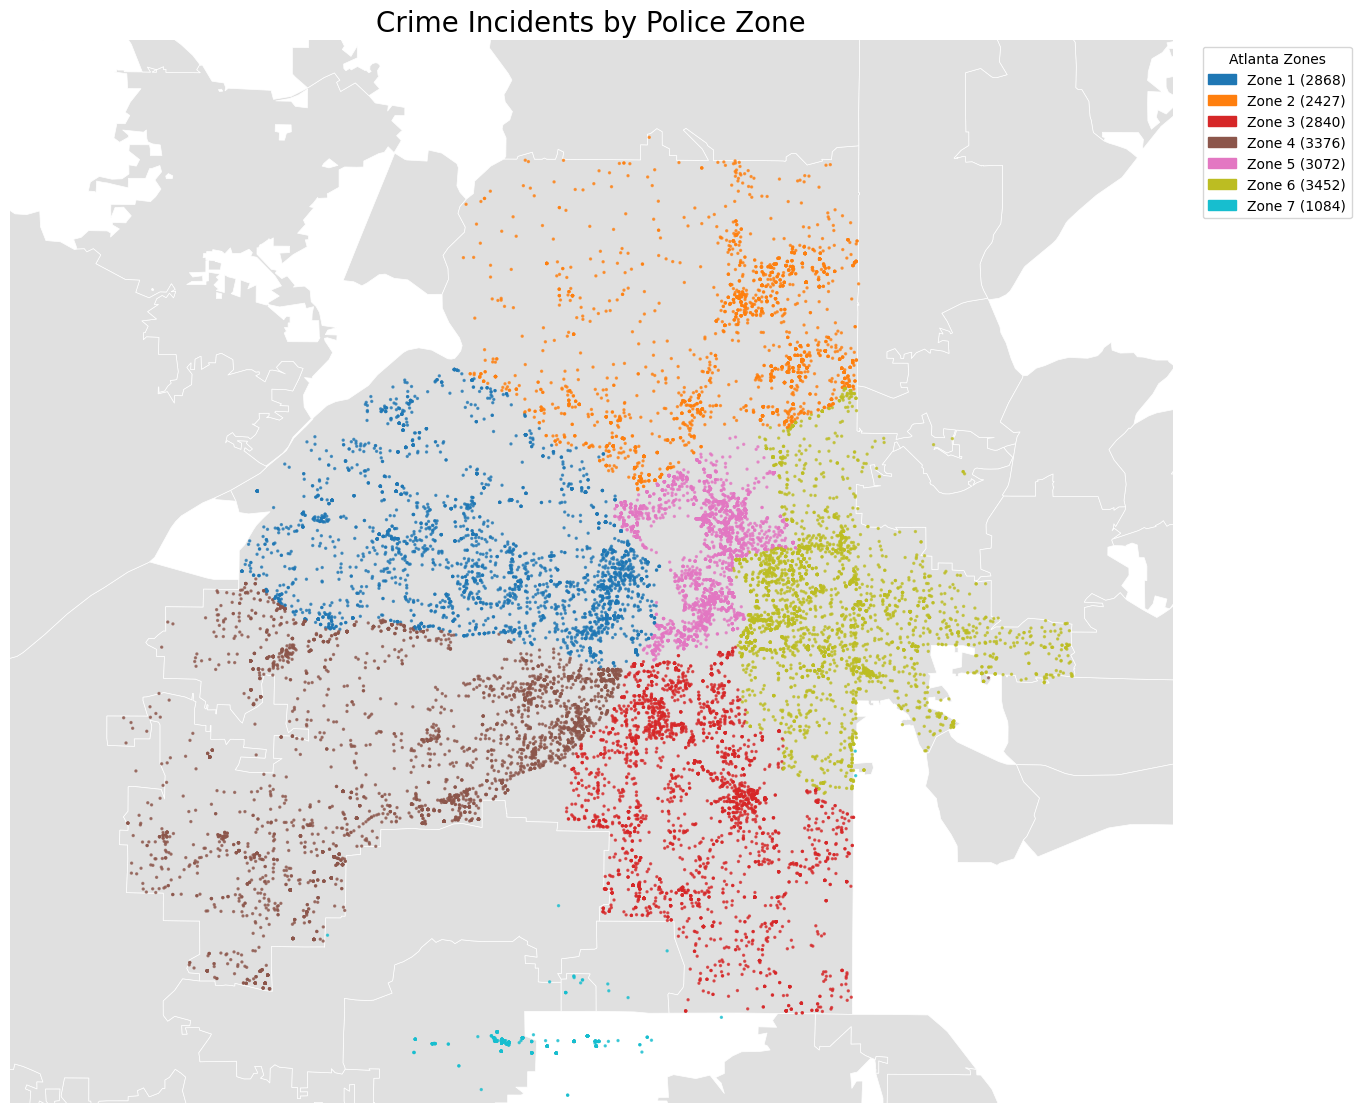

In [34]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from rich.console import Console

# --- 0. Setup ---
console = Console()

# --- 1. LOAD YOUR *NEW* DATA ---
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/cleaned_full_atl_v6.csv" 
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"

console.print("Loading data...", style="bold blue")
final_df = pd.read_csv(crime_csv_path)
cities = gpd.read_file(cities_shp)

# --- 2. CONVERT CRIME DATA TO GeoDataFrame ---
console.print(f"Converting [cyan]{len(final_df)}[/cyan] crime points...", style="bold blue")
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326"
)

# --- 3. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = cities.crs
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)

# --- 4. NEW: FILTER OUT THE MISSING ROW ---
original_count = len(gdf_crime)
gdf_crime = gdf_crime.dropna(subset=['Zone_int_cleaned'])
dropped_count = original_count - len(gdf_crime)
console.print(f"Dropped [yellow]{dropped_count}[/yellow] row(s) with missing Zone.", style="dim")

# --- 5. PLOT BY YOUR 'Zone_int_cleaned' COLUMN ---
console.print("Plotting crime points by 'Zone_int_cleaned'...", style="bold blue")
fig, ax = plt.subplots(figsize=(15, 15))

# Plot basemap
cities.plot(ax=ax, color='#E0E0E0', edgecolor='white', linewidth=0.5)

gdf_crime.plot(
    ax=ax,
    column='Zone_int_cleaned', 
    categorical=True,
    cmap='tab10',
    markersize=2,
    alpha=0.7,
    legend=False
    # No 'missing_kwds' needed anymore
)

# --- 6. BUILD THE CUSTOM LEGEND (SIMPLIFIED) ---
console.print("Building custom legend with counts...", style="dim")

# Get counts (no need for dropna=False anymore)
zone_counts = gdf_crime['Zone_int_cleaned'].value_counts().sort_index()

# Get valid zones to map colors
unique_zones = zone_counts.index.tolist()
num_zones = len(unique_zones)
cmap = plt.get_cmap('tab10')
norm = mcolors.Normalize(vmin=0, vmax=num_zones - 1)

color_map = {zone: cmap(norm(i)) for i, zone in enumerate(unique_zones)}
legend_patches = []

# Add valid zones
for zone in unique_zones:
    label = f"Zone {int(zone)} ({zone_counts[zone]})" 
    patch = mpatches.Patch(color=color_map[zone], label=label)
    legend_patches.append(patch)

# No 'nan_keys' block needed anymore

ax.legend(
    handles=legend_patches,
    title='Atlanta Zones',
    loc='upper left', 
    bbox_to_anchor=(1.02, 1)
)

# --- 7. CLEAN UP ---
ax.set_aspect('equal')
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)
ax.set_title("Crime Incidents by Police Zone", fontsize=20)
ax.axis('off')

console.print("Plot generated successfully.", style="bold green")
plt.show()

In [35]:
import pandas as pd
from rich.console import Console

# --- 0. Setup ---
console = Console()

# --- 1. Define File Paths ---
in_file = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/eda_v6/cleaned_full_atl_v6.csv"
out_file = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.csv"

# --- 2. Load Data ---
console.print(f"Loading data from [cyan]{in_file}[/cyan]...", style="bold blue")
try:
    df = pd.read_csv(in_file)
except FileNotFoundError:
    console.print(f"Error: File not found at {in_file}", style="bold red")
    exit()

# --- 3. Filter and Save ---
original_count = len(df)
console.print(f"Original row count: [bold yellow]{original_count}[/bold yellow]")

# Drop the row(s) with no Zone_int_cleaned value
df_cleaned = df.dropna(subset=['Zone_int_cleaned'])

dropped_count = original_count - len(df_cleaned)
console.print(f"Dropped [yellow]{dropped_count}[/yellow] row(s) with missing Zone.")

# Save the new v7 file
df_cleaned.to_csv(out_file, index=False)
console.print(f"\n--- SUCCESS! ---", style="bold green")
console.print(f"Saved cleaned data to: [cyan]{out_file}[/cyan]")

Loading data from 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/eda_v6/cleaned_full_atl_v6.csv..
.

Original row count: 19120

Dropped 1 row(s) with missing Zone.

--- SUCCESS! ---

Saved cleaned data to: 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.csv

In [36]:
import geopandas as gpd
import pandas as pd
from rich.console import Console
from rich.table import Table

# --- 0. Setup ---
console = Console()

# --- 1. SET YOUR FILE PATHS ---
# Input is the v7 file we just created
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.csv"

# --- !!! UPDATE THIS PATH !!! ---
npu_shp_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_Data.shp" # e.g., ".../shape_files/NPUs/NPUs.shp"
# --- !!! UPDATE THIS PATH !!! ---

# This will be your final file for analysis
output_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.5.csv"

# --- 2. LOAD YOUR DATA ---
console.print(f"Loading crime data from [cyan]{crime_csv_path}[/cyan]...", style="bold blue")
df = pd.read_csv(crime_csv_path)

console.print(f"Loading NPU shapefile from [cyan]{npu_shp_path}[/cyan]...", style="bold blue")
try:
    npu_map = gpd.read_file(npu_shp_path)
except Exception as e:
    console.print(f"Error loading NPU shapefile: {e}", style="bold red")
    console.print("Please ensure the path is correct and you have all associated files (.shx, .dbf, etc.)", style="dim")
    exit()

# --- 3. CONVERT CRIME DATA TO GeoDataFrame ---
console.print("Converting crime data to GeoDataFrame...", style="dim")
gdf_crime = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326" 
)

# --- 4. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = npu_map.crs 
gdf_crime = gdf_crime.to_crs(target_crs)

# --- 5. PREPARE NPU DATA FOR JOIN ---
# The official NPU file uses 'NPU' as the column name
if 'NPU' not in npu_map.columns:
    console.print(f"Columns in NPU file: {npu_map.columns}", style="yellow")
    console.print("Warning: 'NPU' column not found. Using 'NAME' as fallback.", style="bold yellow")
    npu_col = 'NAME'
else:
    npu_col = 'NPU'
    
console.print(f"Using NPU column: [cyan]{npu_col}[/cyan]", style="dim")
npu_join = npu_map[[npu_col, 'geometry']]
npu_join = npu_join.rename(columns={npu_col: 'npu_label'}) 

# --- 6. PERFORM THE SPATIAL JOIN ---
console.print("Joining crime points to NPU boundaries...", style="bold blue")
final_gdf = gpd.sjoin(gdf_crime, npu_join, how="left", predicate="within")

# --- 7. CLEAN UP AND SAVE ---
final_df_to_save = pd.DataFrame(final_gdf.drop(columns=['geometry', 'index_right'], errors='ignore'))
final_df_to_save.to_csv(output_csv_path, index=False)

console.print(f"\n--- SUCCESS! ---", style="bold green")
console.print(f"Saved final enriched file to: [cyan]{output_csv_path}[/cyan]")

# --- 8. REVIEW YOUR NEW FEATURE ---
console.print("\n--- NPU Label Counts (Top 25) ---", style="bold")
counts_table = Table(title="NPU Label Counts")
counts_table.add_column("NPU Label", style="dim")
counts_table.add_column("Count", justify="right")

# We use dropna=False to see how many points (e.g., in East Point) didn't get an NPU label
npu_counts = final_df_to_save['npu_label'].value_counts(dropna=False).head(25)
for label, count in npu_counts.items():
    counts_table.add_row(str(label), str(count))
    
console.print(counts_table)

Loading crime data from 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.csv...

Loading NPU shapefile from 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_
Data.shp...

Converting crime data to GeoDataFrame...

Aligning Coordinate Reference Systems...

Using NPU column: NPU

Joining crime points to NPU boundaries...

--- SUCCESS! ---

Saved final enriched file to: 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.5.csv

--- NPU Label Counts (Top 25) ---

  NPU Label Counts   
┏━━━━━━━━━━━┳━━━━━━━┓
┃ NPU Label ┃ Count ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ None      │ 18038 │
│ nan       │  1081 │
└───────────┴───────┘

In [2]:
import geopandas as gpd
import pandas as pd
from rich.console import Console
from rich.table import Table

# --- 0. Setup ---
console = Console()

# --- 1. SET YOUR FILE PATHS ---
# Input is the v7 file (Atlanta-only data)
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.5.csv"
npu_shp_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_Data.shp" 
output_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.6.csv"

# --- 2. LOAD YOUR DATA ---
console.print(f"Loading crime data from [cyan]{crime_csv_path}[/cyan]...", style="bold blue")
df = pd.read_csv(crime_csv_path)

console.print(f"Loading NPU shapefile from [cyan]{npu_shp_path}[/cyan]...", style="bold blue")
try:
    npu_map = gpd.read_file(npu_shp_path)
except Exception as e:
    console.print(f"Error loading NPU shapefile: {e}", style="bold red")
    console.print("Please ensure the path is correct and you have all associated files (.shx, .dbf, etc.)", style="dim")
    exit()

# --- 3. CONVERT CRIME DATA TO GeoDataFrame ---
console.print("Converting crime data to GeoDataFrame...", style="dim")
gdf_crime = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326" 
)

# --- 4. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = npu_map.crs 
gdf_crime = gdf_crime.to_crs(target_crs)

# --- 5. PREPARE NPU DATA FOR JOIN ---
npu_col = 'NPU'
console.print(f"Using NPU column: [cyan]{npu_col}[/cyan]", style="dim")
npu_join = npu_map[[npu_col, 'geometry']]
# Rename to a unique name to avoid any collision
npu_join = npu_join.rename(columns={npu_col: 'npu_label'}) 

# --- 6. PERFORM THE SPATIAL JOIN (FIXED) ---
console.print("Joining crime points to *nearest* NPU boundary...", style="bold blue")

# This is the fix. We use sjoin_nearest instead of predicate="within".
# This finds the closest NPU for every point, solving the "holes" problem.
final_gdf = gpd.sjoin_nearest(
    gdf_crime, 
    npu_join, 
    how="left"
)

console.print("Join complete.", style="bold green")

# --- 7. CLEAN UP AND SAVE ---
# Drop the original 'npu_label' if it exists, plus join columns
final_df_to_save = pd.DataFrame(final_gdf.drop(columns=['geometry', 'index_right', 'npu_label'], errors='ignore'))
# Note: sjoin_nearest may have added a 'distance' col, this is fine.

final_df_to_save.to_csv(output_csv_path, index=False)

console.print(f"\n--- SUCCESS! ---", style="bold green")
console.print(f"Saved final enriched file to: [cyan]{output_csv_path}[/cyan]")

# --- 8. REVIEW YOUR NEW FEATURE ---
console.print("\n--- Final NPU Label Counts ---", style="bold")
counts_table = Table(title="NPU Label Counts")
counts_table.add_column("NPU Label", style="dim")
counts_table.add_column("Count", justify="right")

# dropna=False should show 0 NaNs, since v7 is Atlanta-only
npu_counts = final_df_to_save['npu_label'].value_counts(dropna=False).head(25)
for label, count in npu_counts.items():
    counts_table.add_row(str(label), str(count))
    
console.print(counts_table)

Loading crime data from 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.5.csv...

Loading NPU shapefile from 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_
Data.shp...

Converting crime data to GeoDataFrame...

Aligning Coordinate Reference Systems...

Using NPU column: NPU

Joining crime points to *nearest* NPU boundary...

Join complete.

--- SUCCESS! ---

Saved final enriched file to: 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.6.csv

--- Final NPU Label Counts ---

KeyError: 'npu_label'

In [5]:
import geopandas as gpd
import pandas as pd
from rich.console import Console
from rich.table import Table

# --- 0. Setup ---
console = Console()

# --- 1. SET YOUR FILE PATHS ---
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.5.csv"
npu_shp_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_Data.shp" 
output_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.6.csv"

# --- 2. LOAD YOUR DATA ---
console.print(f"Loading crime data from [cyan]{crime_csv_path}[/cyan]...", style="bold blue")
df = pd.read_csv(crime_csv_path)

# DROP the old npu_label column if it exists
if 'npu_label' in df.columns:
    console.print("[yellow]Dropping existing 'npu_label' column from crime data...[/yellow]")
    df = df.drop(columns=['npu_label'])

console.print(f"Loading NPU shapefile from [cyan]{npu_shp_path}[/cyan]...", style="bold blue")
try:
    npu_map = gpd.read_file(npu_shp_path)
except Exception as e:
    console.print(f"Error loading NPU shapefile: {e}", style="bold red")
    console.print("Please ensure the path is correct and you have all associated files (.shx, .dbf, etc.)", style="dim")
    exit()

# --- 3. CONVERT CRIME DATA TO GeoDataFrame ---
console.print("Converting crime data to GeoDataFrame...", style="dim")
gdf_crime = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326" 
)

# --- 4. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = npu_map.crs 
gdf_crime = gdf_crime.to_crs(target_crs)

# --- 5. PREPARE NPU DATA FOR JOIN ---
# Use the 'NAME' column which contains the actual NPU letters (M, Y, L, V, B, etc.)
npu_col = 'NAME'  # This is the column with NPU letters
    
console.print(f"Using NPU column: [cyan]{npu_col}[/cyan]", style="dim")
npu_join = npu_map[[npu_col, 'geometry']]
npu_join = npu_join.rename(columns={npu_col: 'npu_label'}) 

# --- 6. PERFORM THE SPATIAL JOIN ---
console.print("Joining crime points to *nearest* NPU boundary...", style="bold blue")
final_gdf = gpd.sjoin_nearest(
    gdf_crime, 
    npu_join, 
    how="left"
)
console.print("Join complete.", style="bold green")

# --- 7. CLEAN UP AND SAVE ---
final_df_to_save = pd.DataFrame(final_gdf.drop(columns=['geometry', 'index_right'], errors='ignore'))

final_df_to_save.to_csv(output_csv_path, index=False)

console.print(f"\n--- SUCCESS! ---", style="bold green")
console.print(f"Saved final enriched file to: [cyan]{output_csv_path}[/cyan]")

# --- 8. REVIEW YOUR NEW FEATURE ---
console.print("\n--- Final NPU Label Counts ---", style="bold")
counts_table = Table(title="NPU Label Counts")
counts_table.add_column("NPU Label", style="dim")
counts_table.add_column("Count", justify="right")

npu_counts = final_df_to_save['npu_label'].value_counts(dropna=False).head(25)
for label, count in npu_counts.items():
    counts_table.add_row(str(label), str(count))
    
console.print(counts_table)

Loading crime data from 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.5.csv...

Dropping existing 'npu_label' column from crime data...

Loading NPU shapefile from 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_
Data.shp...

Converting crime data to GeoDataFrame...

Aligning Coordinate Reference Systems...

Using NPU column: NAME

Joining crime points to *nearest* NPU boundary...

Join complete.

--- SUCCESS! ---

Saved final enriched file to: 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v7.6.csv

--- Final NPU Label Counts ---

  NPU Label Counts   
┏━━━━━━━━━━━┳━━━━━━━┓
┃ NPU Label ┃ Count ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ M         │  2203 │
│ E         │  2091 │
│ X         │  1641 │
│ B         │  1278 │
│ V         │   876 │
│ R         │   849 │
│ W         │   810 │
│ F         │   772 │
│ T         │   768 │
│ Z         │   767 │
│ I         │   756 │
│ N         │   701 │
│ S         │   659 │
│ Y         │   614 │
│ P         │   606 │
│ J         │   574 │
│ D         │   543 │
│ H         │   541 │
│ L         │   527 │
│ O         │   509 │
│ G         │   355 │
│ K         │   301 │
│ C         │   250 │
│ A         │   114 │
│ Q         │    14 │
└───────────┴───────┘

Loading data...

Converting 19119 crime points...

Aligning Coordinate Reference Systems...

Plotting crime points by 'npu_label'...

Building custom legend with counts...

Plot generated successfully.

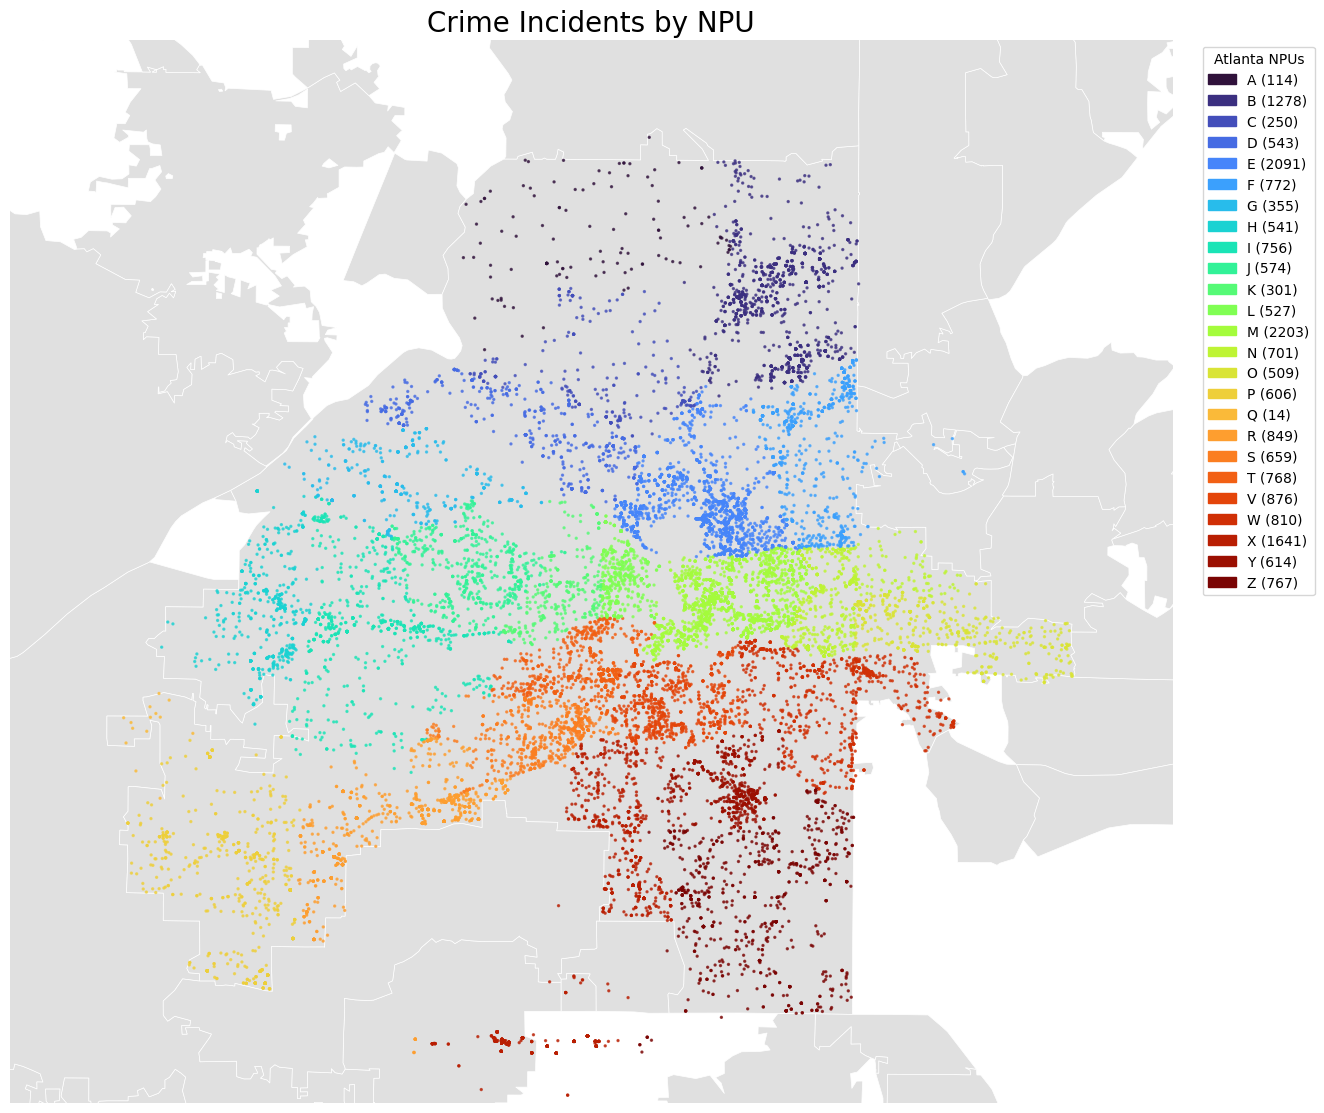

In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from rich.console import Console

# --- 0. Setup ---
console = Console()

# --- 1. LOAD YOUR *FINAL* DATA ---
# This is the file we created in the last step
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v8.csv" 
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"

console.print("Loading data...", style="bold blue")
final_df = pd.read_csv(crime_csv_path)
cities = gpd.read_file(cities_shp)

# --- 2. CONVERT CRIME DATA TO GeoDataFrame ---
console.print(f"Converting [cyan]{len(final_df)}[/cyan] crime points...", style="bold blue")
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326"
)

# --- 3. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = cities.crs
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)

# --- 4. (No filtering needed, this file is clean) ---

# --- 5. PLOT BY YOUR 'npu_label' COLUMN ---
console.print("Plotting crime points by 'npu_label'...", style="bold blue")
fig, ax = plt.subplots(figsize=(15, 15))

# Plot basemap
cities.plot(ax=ax, color='#E0E0E0', edgecolor='white', linewidth=0.5)

# Plot crime data
gdf_crime.plot(
    ax=ax,
    column='npu_label', # <-- Changed to NPU
    categorical=True,
    # Switched to 'turbo' as it has >20 distinct colors for your 25 NPUs
    cmap='turbo', 
    markersize=2,
    alpha=0.7,
    legend=False
)

# --- 6. BUILD THE CUSTOM LEGEND ---
console.print("Building custom legend with counts...", style="dim")

# Get counts
npu_counts = gdf_crime['npu_label'].value_counts().sort_index()

# Get valid NPUs to map colors
unique_npus = npu_counts.index.tolist()
num_npus = len(unique_npus)
cmap = plt.get_cmap('turbo') # <-- Match the plot cmap
norm = mcolors.Normalize(vmin=0, vmax=num_npus - 1)

color_map = {npu: cmap(norm(i)) for i, npu in enumerate(unique_npus)}
legend_patches = []

# Add valid NPUs
for npu in unique_npus:
    label = f"{npu} ({npu_counts[npu]})" # <-- Updated label format
    patch = mpatches.Patch(color=color_map[npu], label=label)
    legend_patches.append(patch)

ax.legend(
    handles=legend_patches,
    title='Atlanta NPUs', # <-- Updated title
    loc='upper left', 
    bbox_to_anchor=(1.02, 1)
)

# --- 7. CLEAN UP ---
ax.set_aspect('equal')
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)
ax.set_title("Crime Incidents by NPU", fontsize=20) # <-- Updated title
ax.axis('off')

console.print("Plot generated successfully.", style="bold green")
plt.show()

Loading data...

Converting 19119 crime points...

Aligning Coordinate Reference Systems...

Plotting crime points by 'npu_label'...

Building custom legend with counts...

Plot generated successfully.

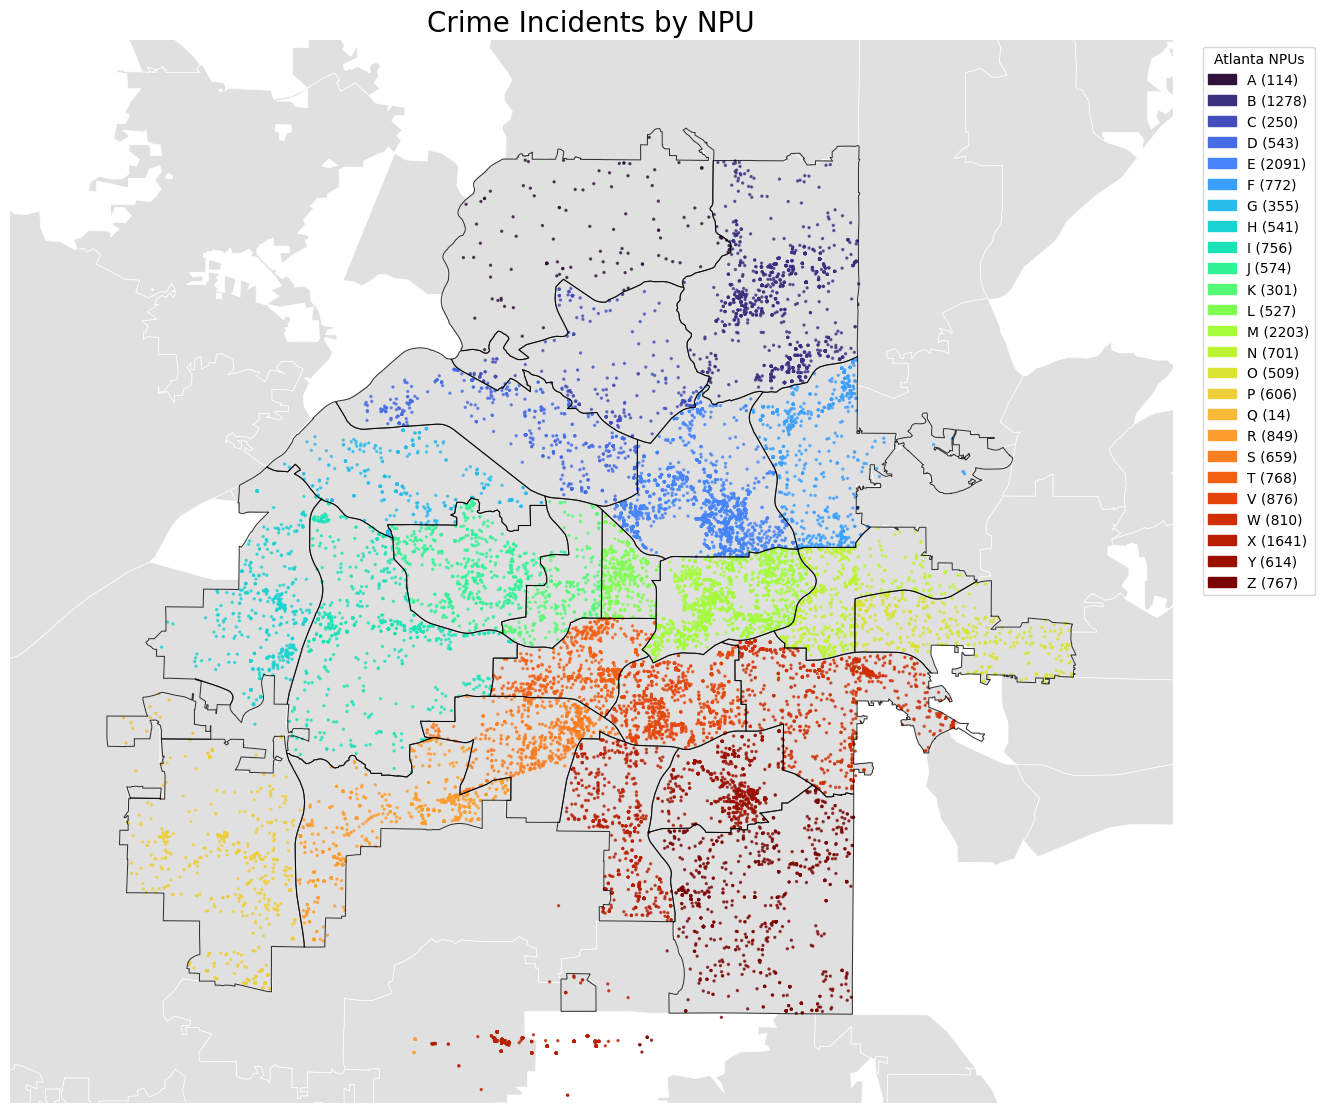

In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from rich.console import Console

# --- 0. Setup ---
console = Console()

# --- 1. LOAD YOUR DATA ---
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v8.csv" 
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"
# --- NEW: Load the NPU map itself ---
npu_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_Data.shp"

console.print("Loading data...", style="bold blue")
final_df = pd.read_csv(crime_csv_path)
cities = gpd.read_file(cities_shp)
npu_map = gpd.read_file(npu_shp) # <-- NEW

# --- 2. CONVERT CRIME DATA TO GeoDataFrame ---
console.print(f"Converting [cyan]{len(final_df)}[/cyan] crime points...", style="bold blue")
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326"
)

# --- 3. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = cities.crs
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)
npu_map = npu_map.to_crs(target_crs) # <-- NEW

# --- 5. PLOT BY YOUR 'npu_label' COLUMN ---
console.print("Plotting crime points by 'npu_label'...", style="bold blue")
fig, ax = plt.subplots(figsize=(15, 15))

# Layer 1: Plot basemap
cities.plot(ax=ax, color='#E0E0E0', edgecolor='white', linewidth=0.5)

# Layer 2: Plot crime data
gdf_crime.plot(
    ax=ax,
    column='npu_label', 
    categorical=True,
    cmap='turbo', 
    markersize=2,
    alpha=0.7,
    legend=False
)

# --- NEW: Layer 3: Plot the NPU outlines on top ---
npu_map.plot(
    ax=ax,
    color='none',          # Don't fill the polygons
    edgecolor='black',   # Draw the outlines in black
    linewidth=0.75,      # Make the lines visible
    alpha=0.8
)
# --- END NEW ---

# --- 6. BUILD THE CUSTOM LEGEND ---
console.print("Building custom legend with counts...", style="dim")
npu_counts = gdf_crime['npu_label'].value_counts().sort_index()

unique_npus = npu_counts.index.tolist()
num_npus = len(unique_npus)
cmap = plt.get_cmap('turbo') 
norm = mcolors.Normalize(vmin=0, vmax=num_npus - 1)

color_map = {npu: cmap(norm(i)) for i, npu in enumerate(unique_npus)}
legend_patches = []

for npu in unique_npus:
    label = f"{npu} ({npu_counts[npu]})" 
    patch = mpatches.Patch(color=color_map[npu], label=label)
    legend_patches.append(patch)

ax.legend(
    handles=legend_patches,
    title='Atlanta NPUs', 
    loc='upper left', 
    bbox_to_anchor=(1.02, 1)
)

# --- 7. CLEAN UP ---
ax.set_aspect('equal') # This is critical to prevent distortion
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)
ax.set_title("Crime Incidents by NPU", fontsize=20) 
ax.axis('off')

console.print("Plot generated successfully.", style="bold green")
plt.show()

Loading data...

Converting 19119 crime points...

Aligning Coordinate Reference Systems...

Plotting crime points by 'npu_label' and adding NPU labels...

Building custom legend with counts...

Plot generated successfully.

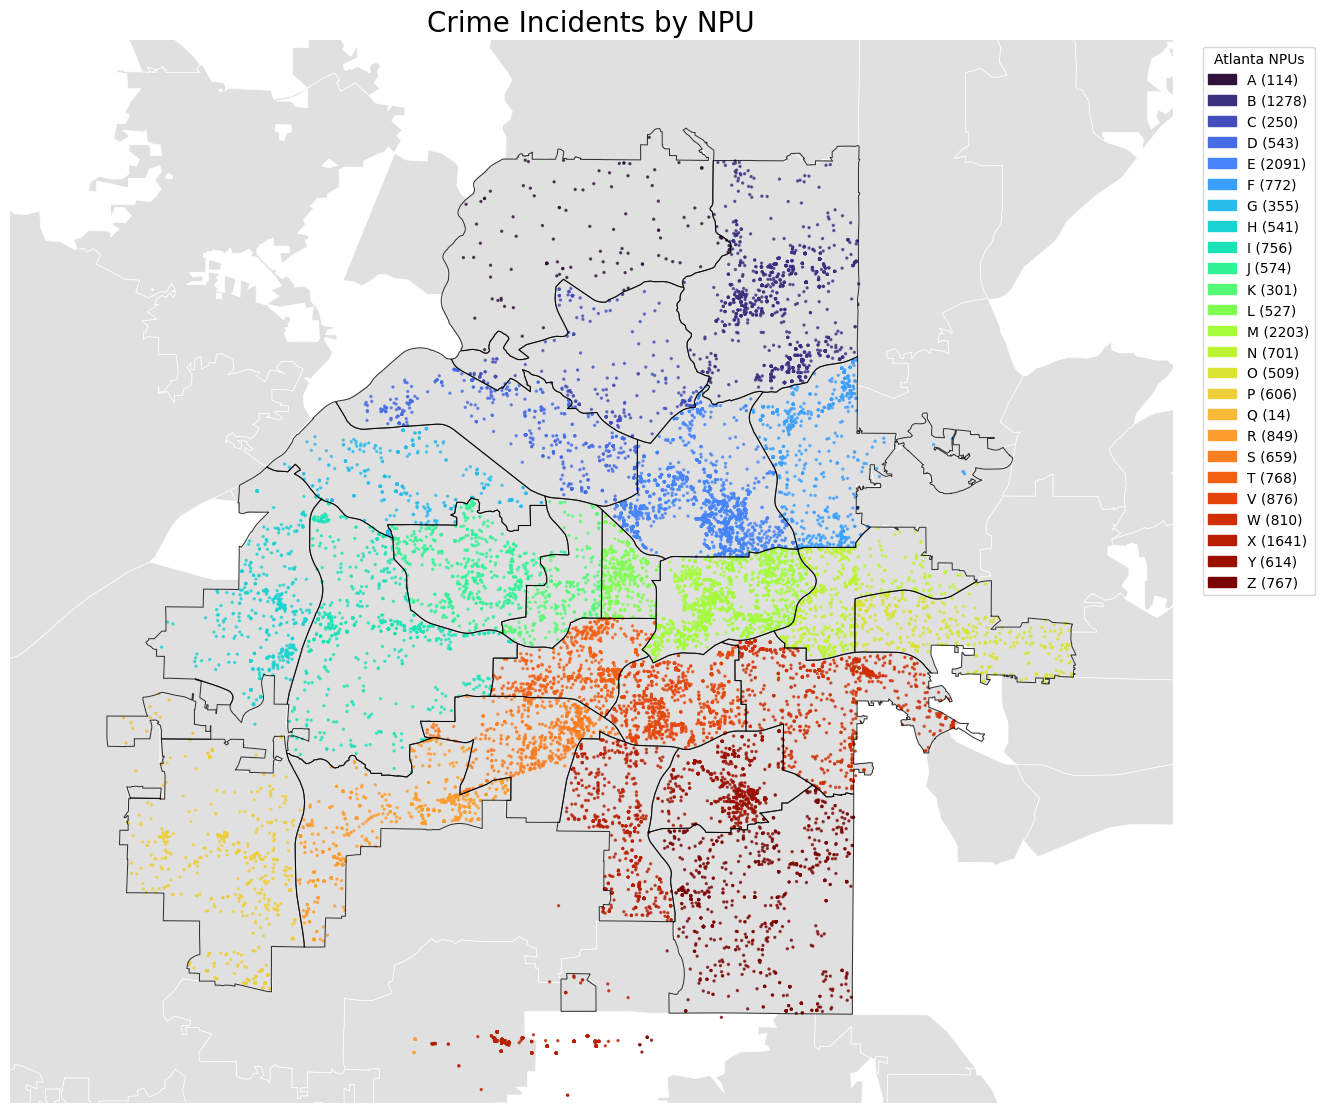

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from rich.console import Console

# --- 0. Setup ---
console = Console()

# --- 1. LOAD YOUR DATA ---
# Updated to your new v8 file
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v8.csv" 
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"
npu_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_Data.shp"

console.print("Loading data...", style="bold blue")
final_df = pd.read_csv(crime_csv_path)
cities = gpd.read_file(cities_shp)
npu_map = gpd.read_file(npu_shp) 

# --- 2. CONVERT CRIME DATA TO GeoDataFrame ---
console.print(f"Converting [cyan]{len(final_df)}[/cyan] crime points...", style="bold blue")
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326"
)

# --- 3. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = cities.crs
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)
npu_map = npu_map.to_crs(target_crs) 

# --- 5. PLOT BY YOUR 'npu_label' COLUMN ---
console.print("Plotting crime points by 'npu_label' and adding NPU labels...", style="bold blue")
fig, ax = plt.subplots(figsize=(15, 15))

# Layer 1: Plot basemap
cities.plot(ax=ax, color='#E0E0E0', edgecolor='white', linewidth=0.5)

# Layer 2: Plot crime data
gdf_crime.plot(
    ax=ax,
    column='npu_label', 
    categorical=True,
    cmap='turbo', 
    markersize=2,
    alpha=0.7,
    legend=False
)

# Layer 3: Plot the NPU outlines
npu_map.plot(
    ax=ax,
    color='none',          
    edgecolor='black',   
    linewidth=0.75,      
    alpha=0.8
)

# --- NEW: Layer 4: Add NPU labels to the map ---
# We need the 'npu_label' (e.g., 'NPU-A') and the geometry from the npu_map
# Assuming the 'NPU' column in npu_map contains the single letter or 'NPU-A' format
for idx, row in npu_map.iterrows():
    # Ensure 'NPU' column exists and contains the NPU identifier
    if 'NPU' in row and row['NPU'] is not None:
        npu_id = row['NPU'].replace('NPU-', '') # Extract just the letter (A, B, C...)
        
        # Calculate centroid for placing the label
        # Handle potential empty or invalid geometries
        if row.geometry.is_valid and not row.geometry.is_empty:
            centroid = row.geometry.centroid
            ax.text(
                centroid.x, 
                centroid.y, 
                npu_id, 
                fontsize=10, 
                ha='center', 
                va='center', 
                color='white',
                fontweight='bold',
                # This makes the text visible against various background colors
                path_effects=[mpe.Stroke(linewidth=2, foreground='black'), mpe.Normal()] 
            )
# To use path_effects, you need to import it:
import matplotlib.patheffects as mpe # <-- Add this import at the top with other matplotlib imports
# --- END NEW ---

# --- 6. BUILD THE CUSTOM LEGEND ---
console.print("Building custom legend with counts...", style="dim")
npu_counts = gdf_crime['npu_label'].value_counts().sort_index()

unique_npus = npu_counts.index.tolist()
num_npus = len(unique_npus)
cmap = plt.get_cmap('turbo') 
norm = mcolors.Normalize(vmin=0, vmax=num_npus - 1)

color_map = {npu: cmap(norm(i)) for i, npu in enumerate(unique_npus)}
legend_patches = []

for npu in unique_npus:
    label = f"{npu} ({npu_counts[npu]})" 
    patch = mpatches.Patch(color=color_map[npu], label=label)
    legend_patches.append(patch)

ax.legend(
    handles=legend_patches,
    title='Atlanta NPUs', 
    loc='upper left', 
    bbox_to_anchor=(1.02, 1)
)

# --- 7. CLEAN UP ---
ax.set_aspect('equal') 
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)
ax.set_title("Crime Incidents by NPU", fontsize=20) 
ax.axis('off')

console.print("Plot generated successfully.", style="bold green")
plt.show()

Loading data...

Converting 19119 crime points...

Aligning Coordinate Reference Systems...

Creating improved visualization...

Building legend...

Visualization complete!

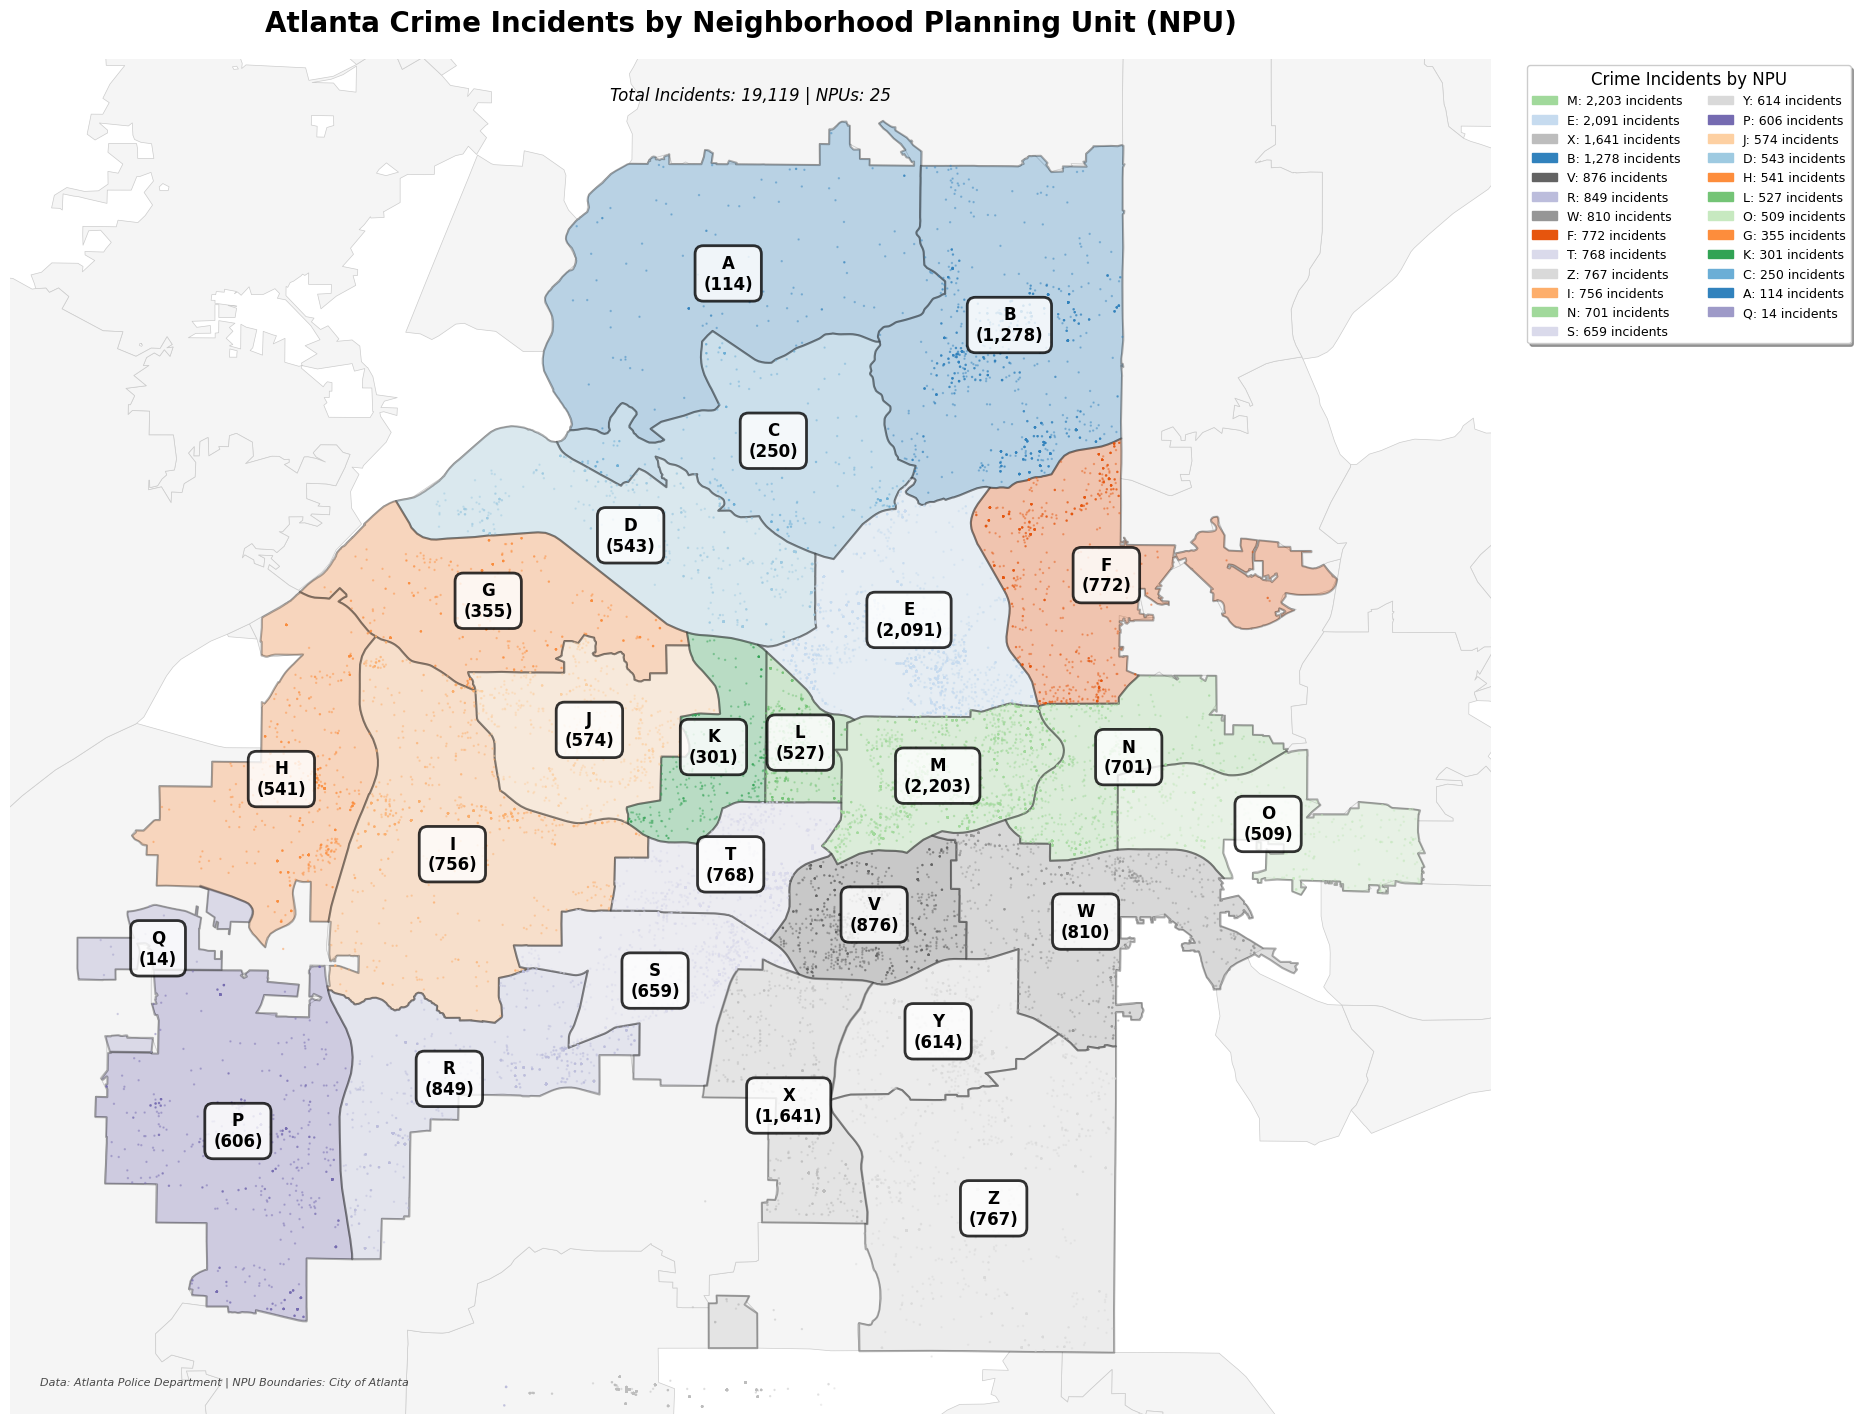

In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from rich.console import Console

# --- 0. Setup ---
console = Console()

# --- 1. LOAD YOUR DATA ---
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v8.csv" 
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"
npu_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_Data.shp"

console.print("Loading data...", style="bold blue")
final_df = pd.read_csv(crime_csv_path)
cities = gpd.read_file(cities_shp)
npu_map = gpd.read_file(npu_shp) 

# --- 2. CONVERT CRIME DATA TO GeoDataFrame ---
console.print(f"Converting [cyan]{len(final_df)}[/cyan] crime points...", style="bold blue")
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326"
)

# --- 3. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = cities.crs
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)
npu_map = npu_map.to_crs(target_crs) 

# --- 4. PREPARE DATA ---
# Get counts for each NPU
npu_counts = gdf_crime['npu_label'].value_counts().sort_index()
unique_npus = npu_counts.index.tolist()

# Create a colormap
num_npus = len(unique_npus)
cmap = plt.get_cmap('tab20c')  # Better discrete colors
norm = mcolors.Normalize(vmin=0, vmax=num_npus - 1)
color_map = {npu: cmap(norm(i)) for i, npu in enumerate(unique_npus)}

# --- 5. CREATE THE PLOT ---
console.print("Creating improved visualization...", style="bold blue")
fig, ax = plt.subplots(figsize=(18, 15))

# Layer 1: Plot basemap (lighter gray for better contrast)
cities.plot(ax=ax, color='#F5F5F5', edgecolor='#CCCCCC', linewidth=0.5)

# Layer 2: Plot NPU boundaries with FILL colors (instead of just points)
# This makes regions much clearer
for npu in unique_npus:
    npu_geom = npu_map[npu_map['NAME'] == npu]
    if len(npu_geom) > 0:
        npu_geom.plot(
            ax=ax,
            color=color_map[npu],
            alpha=0.3,  # Semi-transparent
            edgecolor='black',
            linewidth=1.5
        )

# Layer 3: Plot crime points (smaller and more transparent)
gdf_crime.plot(
    ax=ax,
    column='npu_label',
    categorical=True,
    cmap='tab20c',
    markersize=0.5,  # Much smaller
    alpha=0.4,  # More transparent
    legend=False
)

# Layer 4: Add NPU labels with better styling
for idx, row in npu_map.iterrows():
    if 'NAME' in row and row['NAME'] is not None:
        npu_id = str(row['NAME']).strip()
        
        if row.geometry.is_valid and not row.geometry.is_empty:
            centroid = row.geometry.centroid
            
            # Get count for this NPU
            count = npu_counts.get(npu_id, 0)
            
            # Create label with count
            label_text = f"{npu_id}\n({count:,})"
            
            # Add text with strong outline for visibility
            ax.text(
                centroid.x, 
                centroid.y, 
                label_text,
                fontsize=12,
                ha='center', 
                va='center',
                color='black',
                fontweight='bold',
                bbox=dict(
                    boxstyle='round,pad=0.5',
                    facecolor='white',
                    edgecolor='black',
                    alpha=0.8,
                    linewidth=2
                )
            )

# --- 6. BUILD CLEANER LEGEND ---
console.print("Building legend...", style="dim")
legend_patches = []

# Sort by count (descending) for easier reading
for npu in sorted(unique_npus, key=lambda x: npu_counts[x], reverse=True):
    label = f"{npu}: {npu_counts[npu]:,} incidents"
    patch = mpatches.Patch(color=color_map[npu], label=label)
    legend_patches.append(patch)

# Split legend into two columns if too many NPUs
ncol = 2 if len(legend_patches) > 15 else 1

ax.legend(
    handles=legend_patches,
    title='Crime Incidents by NPU',
    title_fontsize=12,
    fontsize=9,
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    ncol=ncol,
    frameon=True,
    fancybox=True,
    shadow=True
)

# --- 7. FINAL TOUCHES ---
ax.set_aspect('equal')

# Focus on Atlanta
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
if len(atlanta_shape) > 0:
    minx, miny, maxx, maxy = atlanta_shape.total_bounds
    padding = 0.05
    ax.set_xlim(minx - (maxx-minx)*padding, maxx + (maxx-minx)*padding)
    ax.set_ylim(miny - (maxy-miny)*padding, maxy + (maxy-miny)*padding)

# Add title and subtitle
total_incidents = len(gdf_crime)
ax.set_title(
    "Atlanta Crime Incidents by Neighborhood Planning Unit (NPU)",
    fontsize=20,
    fontweight='bold',
    pad=20
)
ax.text(
    0.5, 0.98,
    f"Total Incidents: {total_incidents:,} | NPUs: {len(unique_npus)}",
    transform=ax.transAxes,
    ha='center',
    va='top',
    fontsize=12,
    style='italic'
)

ax.axis('off')

# Add scale bar or north arrow if needed
# Add attribution
ax.text(
    0.02, 0.02,
    "Data: Atlanta Police Department | NPU Boundaries: City of Atlanta",
    transform=ax.transAxes,
    fontsize=8,
    va='bottom',
    ha='left',
    style='italic',
    alpha=0.7
)

plt.tight_layout()
console.print("Visualization complete!", style="bold green")
plt.show()

Loading data...

Converting 19119 crime points...

Aligning Coordinate Reference Systems...

Creating NPU crime density data...

Creating heatmap visualization...

Adding school locations...

NPU Heatmap complete!

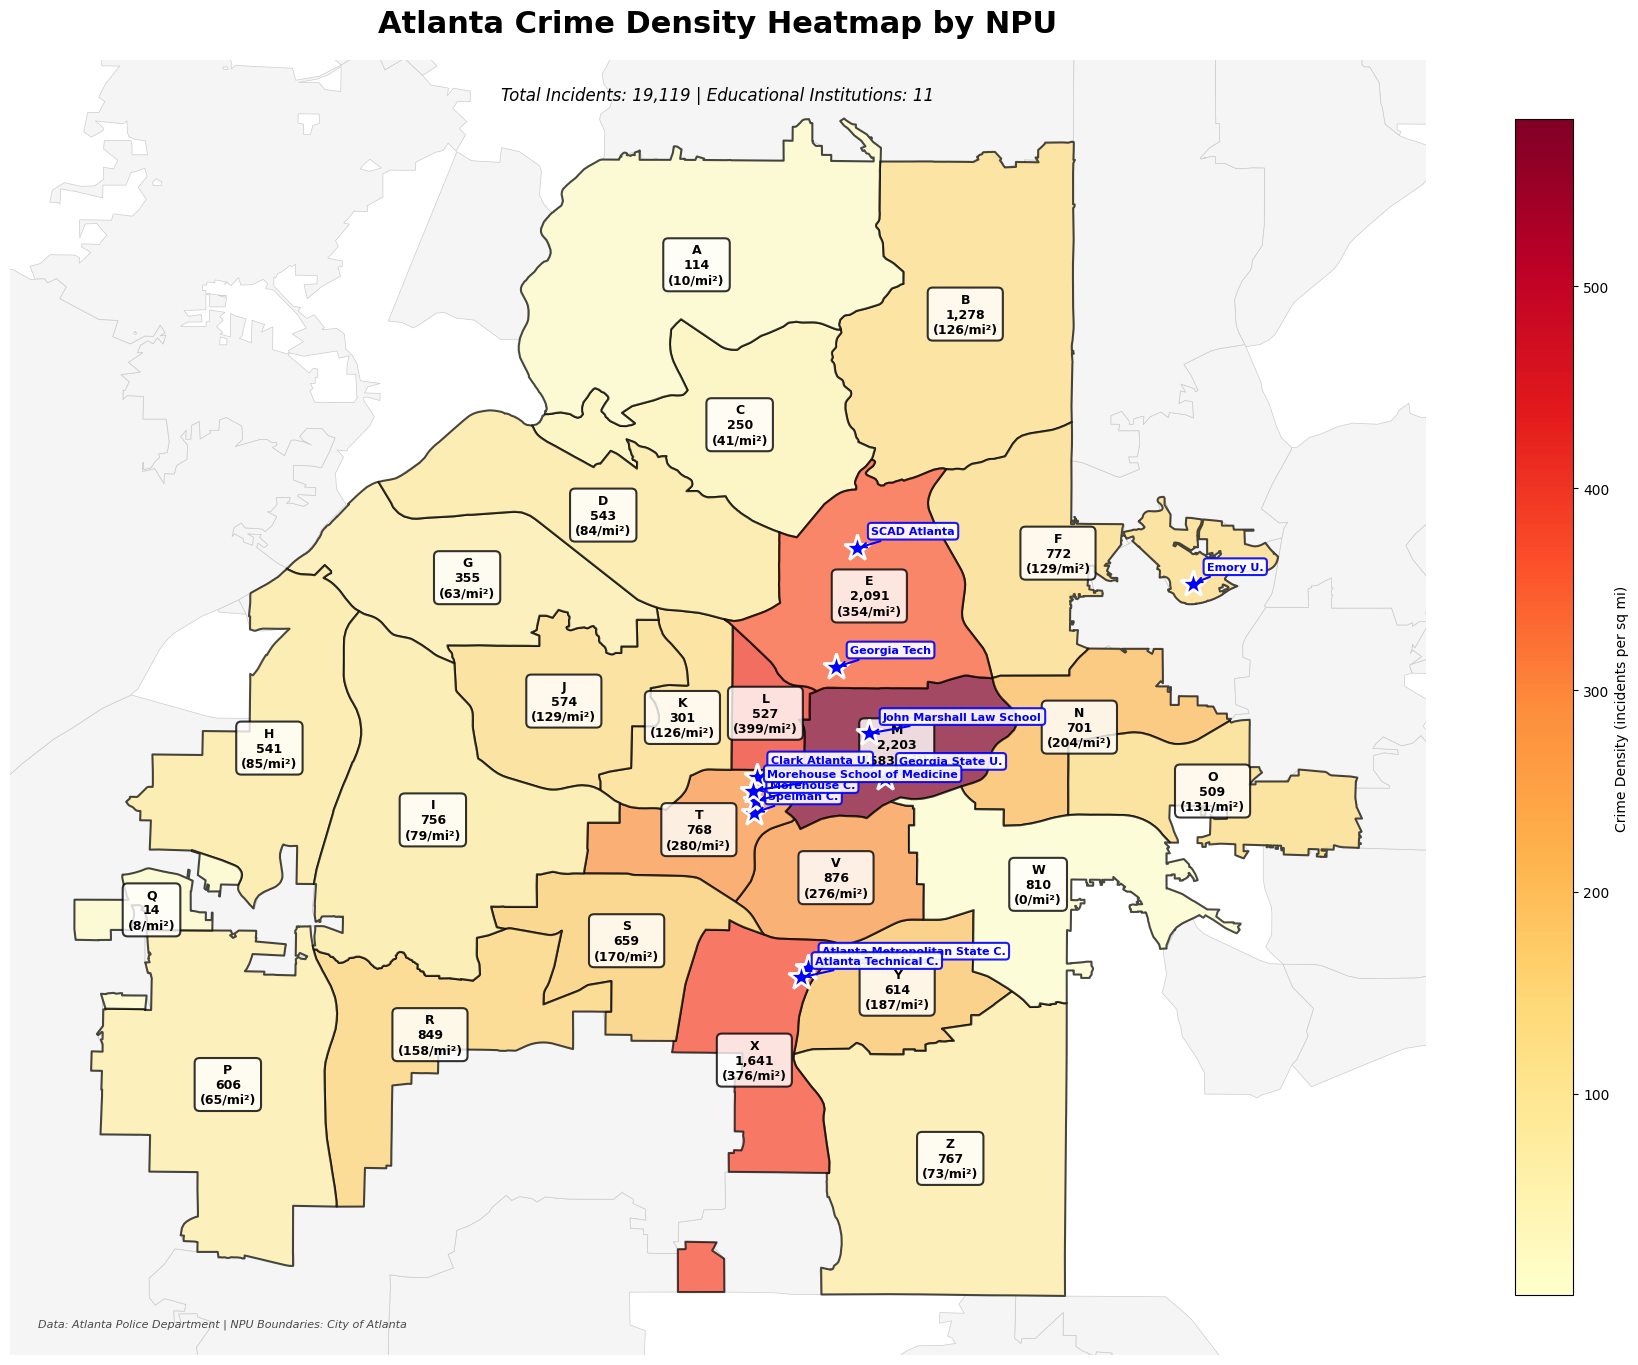

In [11]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from rich.console import Console

# --- 0. Setup ---
console = Console()

# School locations in Atlanta
school_centers = {
    # Main Universities
    'Georgia State University': (33.7530, -84.3863),
    'Georgia Tech': (33.7756, -84.3963),
    'Emory University': (33.7925, -84.3239),
    
    # Atlanta University Center (AUC)
    'Clark Atlanta University': (33.7533, -84.4124),
    'Spelman College': (33.7460, -84.4129),
    'Morehouse College': (33.7483, -84.4126),
    'Morehouse School of Medicine': (33.7505, -84.4131),
    
    # Other Major Campuses
    'Atlanta Metropolitan State College': (33.7145, -84.4020),
    'Atlanta Technical College': (33.7126, -84.4034),
    
    # Specialized/Urban Campuses
    'SCAD Atlanta': (33.7997, -84.3920),
    'John Marshall Law School': (33.7621, -84.3896)
}

# --- 1. LOAD YOUR DATA ---
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v8.csv" 
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"
npu_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_npu/Official_NPU_-_Open_Data.shp"

console.print("Loading data...", style="bold blue")
final_df = pd.read_csv(crime_csv_path)
cities = gpd.read_file(cities_shp)
npu_map = gpd.read_file(npu_shp) 

# --- 2. CONVERT CRIME DATA TO GeoDataFrame ---
console.print(f"Converting [cyan]{len(final_df)}[/cyan] crime points...", style="bold blue")
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326"
)

# --- 3. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = cities.crs
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)
npu_map = npu_map.to_crs(target_crs)

# --- 4. CREATE CHOROPLETH DATA ---
console.print("Creating NPU crime density data...", style="bold blue")

# Count crimes per NPU
npu_counts = gdf_crime['npu_label'].value_counts()

# Merge counts with geometry
npu_map['crime_count'] = npu_map['NAME'].map(npu_counts).fillna(0)

# Calculate crime density (crimes per square mile)
npu_map['crime_density'] = npu_map['crime_count'] / npu_map['SQMILES']

# --- 5. CREATE HEATMAP VISUALIZATION ---
console.print("Creating heatmap visualization...", style="bold blue")
fig, ax = plt.subplots(figsize=(18, 15))

# Layer 1: Plot basemap
cities.plot(ax=ax, color='#F5F5F5', edgecolor='#CCCCCC', linewidth=0.5)

# Layer 2: Choropleth heatmap
npu_map.plot(
    ax=ax,
    column='crime_density',
    cmap='YlOrRd',  # Yellow-Orange-Red colormap
    edgecolor='black',
    linewidth=1.5,
    alpha=0.7,
    legend=True,
    legend_kwds={
        'label': 'Crime Density (incidents per sq mi)',
        'orientation': 'vertical',
        'shrink': 0.8,
        'pad': 0.05
    }
)

# Layer 3: Add NPU labels with counts
for idx, row in npu_map.iterrows():
    if 'NAME' in row and row['NAME'] is not None:
        npu_id = str(row['NAME']).strip()
        
        if row.geometry.is_valid and not row.geometry.is_empty:
            centroid = row.geometry.centroid
            
            count = int(row['crime_count'])
            density = row['crime_density']
            
            label_text = f"{npu_id}\n{count:,}\n({density:.0f}/mi²)"
            
            ax.text(
                centroid.x, 
                centroid.y, 
                label_text,
                fontsize=9,
                ha='center', 
                va='center',
                color='black',
                fontweight='bold',
                bbox=dict(
                    boxstyle='round,pad=0.4',
                    facecolor='white',
                    edgecolor='black',
                    alpha=0.8,
                    linewidth=1.5
                )
            )

# Layer 4: Add school markers
console.print("Adding school locations...", style="dim")
for school_name, (lat, lon) in school_centers.items():
    # Create point and transform to target CRS
    point = gpd.GeoSeries([gpd.points_from_xy([lon], [lat])[0]], crs="EPSG:4326")
    point = point.to_crs(target_crs)
    
    # Plot school marker
    ax.plot(
        point.x, 
        point.y, 
        marker='*',
        color='blue',
        markersize=20,
        markeredgecolor='white',
        markeredgewidth=2,
        zorder=10
    )
    
    # Add school label (abbreviated for clarity)
    school_abbrev = school_name.replace('University', 'U.').replace('College', 'C.')
    ax.annotate(
        school_abbrev,
        xy=(point.x.iloc[0], point.y.iloc[0]),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=8,
        fontweight='bold',
        color='blue',
        bbox=dict(
            boxstyle='round,pad=0.3',
            facecolor='white',
            edgecolor='blue',
            alpha=0.9,
            linewidth=1.5
        ),
        arrowprops=dict(
            arrowstyle='->',
            color='blue',
            lw=1.5
        ),
        zorder=11
    )

# Create custom legend for schools
school_marker = plt.Line2D(
    [], [], 
    marker='*', 
    color='white',
    markerfacecolor='blue',
    markeredgecolor='white',
    markeredgewidth=2,
    markersize=15,
    linestyle='None',
    label='Educational Institutions'
)

# Add to existing legend
handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(
        handles=[school_marker],
        loc='upper left',
        bbox_to_anchor=(1.15, 0.5),
        frameon=True,
        fancybox=True,
        shadow=True
    )

# --- 6. FINAL TOUCHES ---
ax.set_aspect('equal')

# Focus on Atlanta
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
if len(atlanta_shape) > 0:
    minx, miny, maxx, maxy = atlanta_shape.total_bounds
    padding = 0.05
    ax.set_xlim(minx - (maxx-minx)*padding, maxx + (maxx-minx)*padding)
    ax.set_ylim(miny - (maxy-miny)*padding, maxy + (maxy-miny)*padding)

# Add title
total_incidents = len(gdf_crime)
ax.set_title(
    "Atlanta Crime Density Heatmap by NPU",
    fontsize=22,
    fontweight='bold',
    pad=20
)
ax.text(
    0.5, 0.98,
    f"Total Incidents: {total_incidents:,} | Educational Institutions: {len(school_centers)}",
    transform=ax.transAxes,
    ha='center',
    va='top',
    fontsize=12,
    style='italic'
)

ax.axis('off')

# Add attribution
ax.text(
    0.02, 0.02,
    "Data: Atlanta Police Department | NPU Boundaries: City of Atlanta",
    transform=ax.transAxes,
    fontsize=8,
    va='bottom',
    ha='left',
    style='italic',
    alpha=0.7
)

plt.tight_layout()
console.print("NPU Heatmap complete!", style="bold green")
plt.show()

Loading data...

Converting 19119 crime points...

Aligning Coordinate Reference Systems...

Dropped 0 row(s) with missing Zone.

Creating zone boundaries from crime data...

/tmp/ipykernel_157879/3043451453.py:97: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_map['area_sqmi'] = zone_map.geometry.area / 2.59e6  # Convert sq meters to sq miles


✓ Created boundaries for 7 zones

Creating zone heatmap visualization...

Adding school locations...

Zone Heatmap complete!

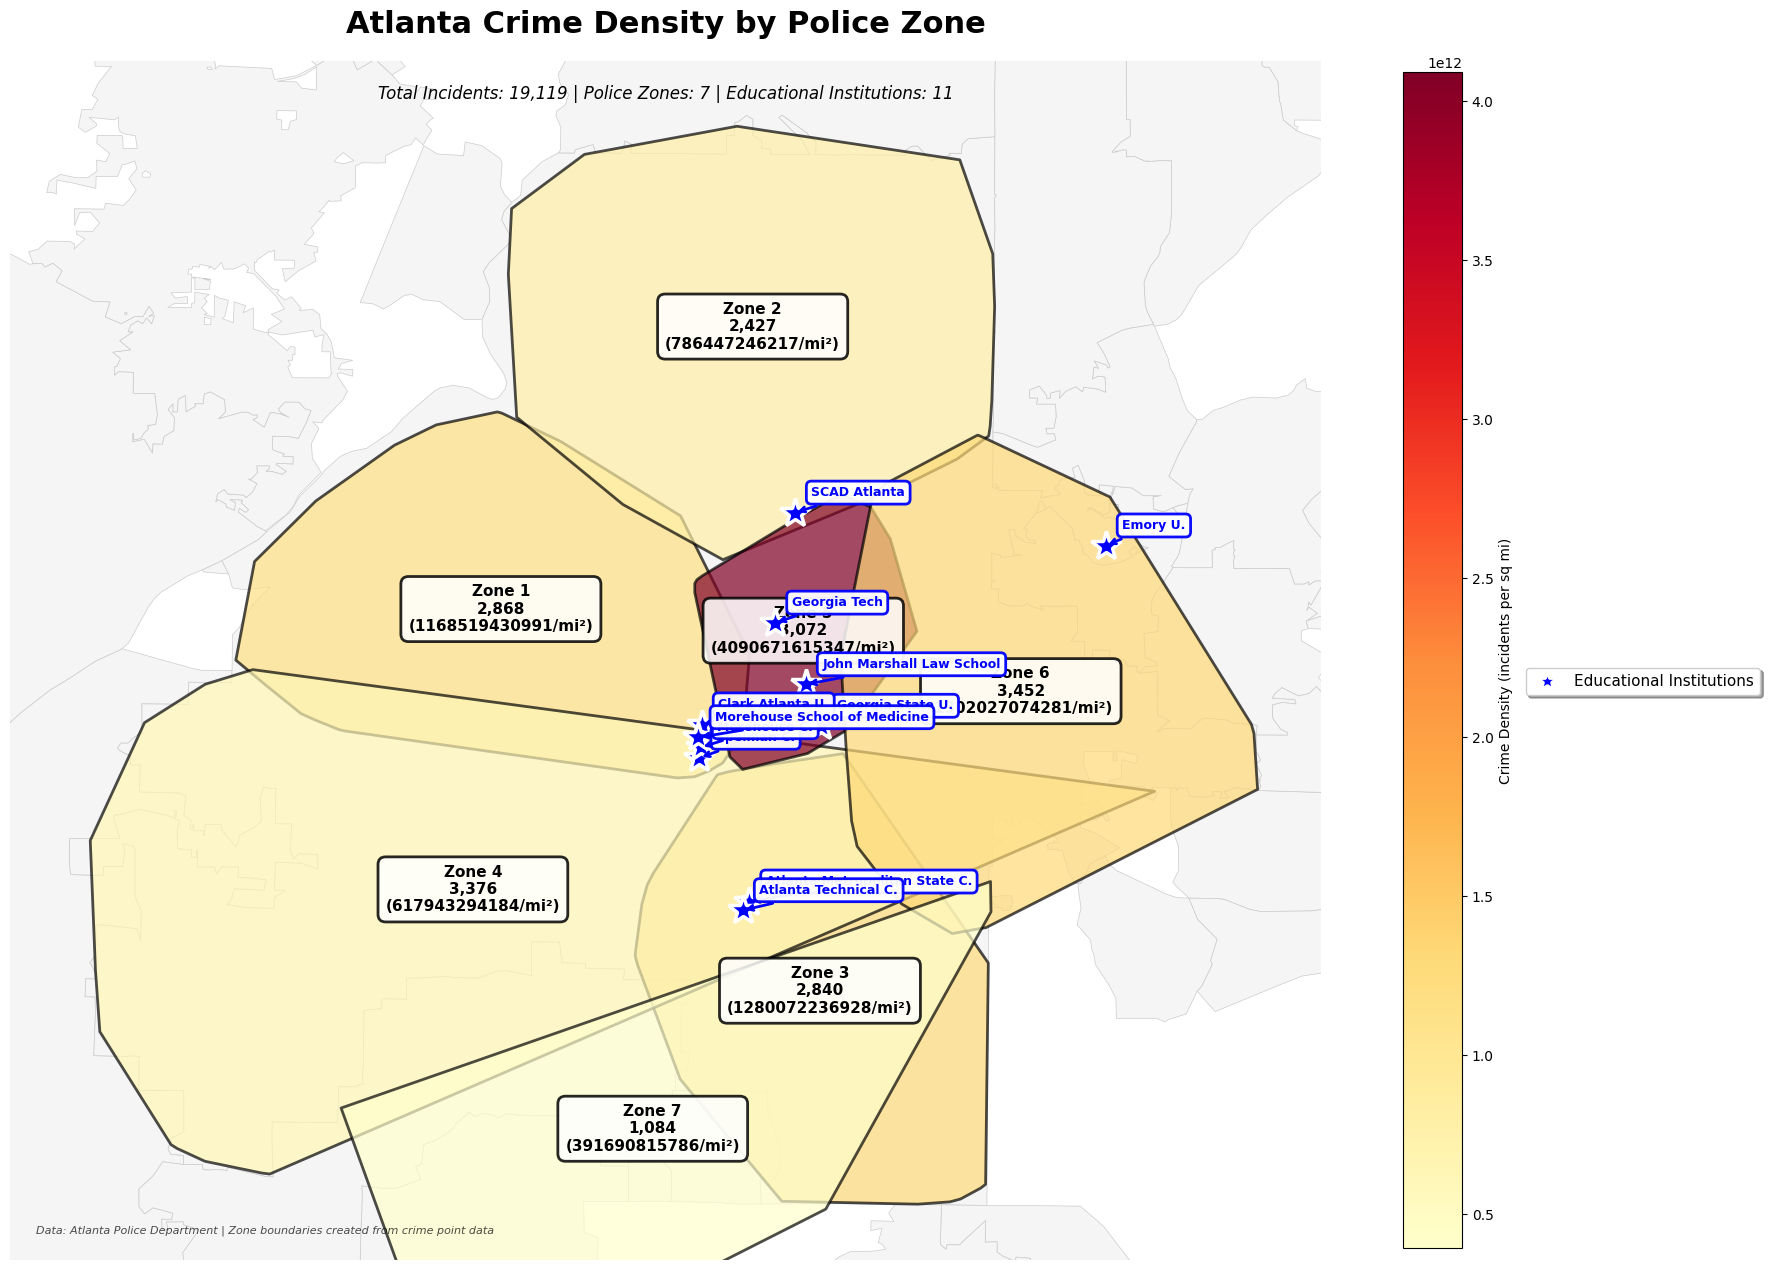

In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from rich.console import Console

# --- 0. Setup ---
console = Console()

# School locations in Atlanta
school_centers = {
    # Main Universities
    'Georgia State University': (33.7530, -84.3863),
    'Georgia Tech': (33.7756, -84.3963),
    'Emory University': (33.7925, -84.3239),
    
    # Atlanta University Center (AUC)
    'Clark Atlanta University': (33.7533, -84.4124),
    'Spelman College': (33.7460, -84.4129),
    'Morehouse College': (33.7483, -84.4126),
    'Morehouse School of Medicine': (33.7505, -84.4131),
    
    # Other Major Campuses
    'Atlanta Metropolitan State College': (33.7145, -84.4020),
    'Atlanta Technical College': (33.7126, -84.4034),
    
    # Specialized/Urban Campuses
    'SCAD Atlanta': (33.7997, -84.3920),
    'John Marshall Law School': (33.7621, -84.3896)
}

# --- 1. LOAD YOUR DATA ---
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/current/cleaned_full_atl_v8.csv" 
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"

console.print("Loading data...", style="bold blue")
final_df = pd.read_csv(crime_csv_path)
cities = gpd.read_file(cities_shp)

# --- 2. CONVERT CRIME DATA TO GeoDataFrame ---
console.print(f"Converting [cyan]{len(final_df)}[/cyan] crime points...", style="bold blue")
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326"
)

# --- 3. ALIGN CRS ---
console.print("Aligning Coordinate Reference Systems...", style="dim")
target_crs = cities.crs
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)

# --- 4. FILTER OUT MISSING ZONES ---
original_count = len(gdf_crime)
gdf_crime = gdf_crime.dropna(subset=['Zone_int_cleaned'])
dropped_count = original_count - len(gdf_crime)
console.print(f"Dropped [yellow]{dropped_count}[/yellow] row(s) with missing Zone.", style="dim")

# --- 5. CREATE ZONE BOUNDARIES FROM CRIME POINTS ---
console.print("Creating zone boundaries from crime data...", style="bold blue")

zone_counts = gdf_crime['Zone_int_cleaned'].value_counts().sort_index()
unique_zones = zone_counts.index.tolist()

zone_geometries = []
for zone in unique_zones:
    zone_crimes = gdf_crime[gdf_crime['Zone_int_cleaned'] == zone]
    
    if len(zone_crimes) > 2:
        # Extract coordinates
        coords = np.array([[geom.x, geom.y] for geom in zone_crimes.geometry])
        
        # Create convex hull
        if len(coords) >= 3:
            try:
                hull = ConvexHull(coords)
                hull_points = coords[hull.vertices]
                polygon = Polygon(hull_points)
                
                zone_geometries.append({
                    'zone_id': int(zone),
                    'geometry': polygon,
                    'crime_count': len(zone_crimes)
                })
            except:
                console.print(f"[yellow]Warning: Could not create hull for Zone {int(zone)}[/yellow]")

# Create GeoDataFrame for zones
zone_map = gpd.GeoDataFrame(zone_geometries, crs=target_crs)

# Calculate area in square miles and crime density
zone_map['area_sqmi'] = zone_map.geometry.area / 2.59e6  # Convert sq meters to sq miles
zone_map['crime_density'] = zone_map['crime_count'] / zone_map['area_sqmi']

console.print(f"✓ Created boundaries for {len(zone_map)} zones", style="green")

# --- 6. CREATE HEATMAP VISUALIZATION ---
console.print("Creating zone heatmap visualization...", style="bold blue")
fig, ax = plt.subplots(figsize=(18, 15))

# Layer 1: Plot basemap
cities.plot(ax=ax, color='#F5F5F5', edgecolor='#CCCCCC', linewidth=0.5)

# Layer 2: Choropleth heatmap
zone_map.plot(
    ax=ax,
    column='crime_density',
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=2,
    alpha=0.7,
    legend=True,
    legend_kwds={
        'label': 'Crime Density (incidents per sq mi)',
        'orientation': 'vertical',
        'shrink': 0.8,
        'pad': 0.05
    }
)

# Layer 3: Add zone labels with counts
for idx, row in zone_map.iterrows():
    if row.geometry.is_valid and not row.geometry.is_empty:
        centroid = row.geometry.centroid
        
        zone_id = int(row['zone_id'])
        count = int(row['crime_count'])
        density = row['crime_density']
        
        label_text = f"Zone {zone_id}\n{count:,}\n({density:.0f}/mi²)"
        
        ax.text(
            centroid.x, 
            centroid.y, 
            label_text,
            fontsize=11,
            ha='center', 
            va='center',
            color='black',
            fontweight='bold',
            bbox=dict(
                boxstyle='round,pad=0.5',
                facecolor='white',
                edgecolor='black',
                alpha=0.85,
                linewidth=2
            )
        )

# Layer 4: Add school markers
console.print("Adding school locations...", style="dim")
for school_name, (lat, lon) in school_centers.items():
    # Create point and transform to target CRS
    point = gpd.GeoSeries([gpd.points_from_xy([lon], [lat])[0]], crs="EPSG:4326")
    point = point.to_crs(target_crs)
    
    # Plot school marker
    ax.plot(
        point.x, 
        point.y, 
        marker='*',
        color='blue',
        markersize=22,
        markeredgecolor='white',
        markeredgewidth=2.5,
        zorder=10
    )
    
    # Add school label (abbreviated for clarity)
    school_abbrev = school_name.replace('University', 'U.').replace('College', 'C.')
    ax.annotate(
        school_abbrev,
        xy=(point.x.iloc[0], point.y.iloc[0]),
        xytext=(12, 12),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        color='blue',
        bbox=dict(
            boxstyle='round,pad=0.4',
            facecolor='white',
            edgecolor='blue',
            alpha=0.95,
            linewidth=2
        ),
        arrowprops=dict(
            arrowstyle='->',
            color='blue',
            lw=2
        ),
        zorder=11
    )

# Create custom legend for schools
school_marker = plt.Line2D(
    [], [], 
    marker='*', 
    color='white',
    markerfacecolor='blue',
    markeredgecolor='white',
    markeredgewidth=2,
    markersize=15,
    linestyle='None',
    label='Educational Institutions'
)

# Add to existing legend
ax.legend(
    handles=[school_marker],
    loc='upper left',
    bbox_to_anchor=(1.15, 0.5),
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=11
)

# --- 7. FINAL TOUCHES ---
ax.set_aspect('equal')

# Focus on Atlanta
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
if len(atlanta_shape) > 0:
    minx, miny, maxx, maxy = atlanta_shape.total_bounds
    padding = 0.05
    ax.set_xlim(minx - (maxx-minx)*padding, maxx + (maxx-minx)*padding)
    ax.set_ylim(miny - (maxy-miny)*padding, maxy + (maxy-miny)*padding)

# Add title
total_incidents = len(gdf_crime)
num_zones = len(zone_map)
ax.set_title(
    "Atlanta Crime Density by Police Zone",
    fontsize=22,
    fontweight='bold',
    pad=20
)
ax.text(
    0.5, 0.98,
    f"Total Incidents: {total_incidents:,} | Police Zones: {num_zones} | Educational Institutions: {len(school_centers)}",
    transform=ax.transAxes,
    ha='center',
    va='top',
    fontsize=12,
    style='italic'
)

ax.axis('off')

# Add attribution
ax.text(
    0.02, 0.02,
    "Data: Atlanta Police Department | Zone boundaries created from crime point data",
    transform=ax.transAxes,
    fontsize=8,
    va='bottom',
    ha='left',
    style='italic',
    alpha=0.7
)

plt.tight_layout()
console.print("Zone Heatmap complete!", style="bold green")
plt.show()